# Comparison between Neural Network and Gradient Boosting Machine in Reserving - on Splice Dataset
-----

This analysis compares the predictive power of a Feed-Forward Neural Network and a Gradient Boosting Machine against the industry-standard Chain Ladder model. The core of this work is to showcase how these modern algorithms can offer significant improvements in performance and to provide a clear understanding of their mechanics, thereby encouraging their wider adoption in actuarial science.

This work is based on https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/research/chain_ladder_to_individual_mdn/#introduction , focusing on the difference between GBM and Neural Network in reserving.

# Import Libraries
-----
We import essential libraries for data processing, neural networks, and visualization.

In addition we import a number of custom functions from the `utils` folder, developed for this notebook but stored separately to simplify this flow and presentation.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from datetime import datetime

# PyTorch imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable


# Scikit-learn imports
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit


import chainladder as cl
import math
import random
import shap


# Local imports
from utils.config import ExperimentConfig, load_config_from_yaml
from utils.neural_networks import TabularNetRegressor, BasicLogGRU, ColumnKeeper, Make3D
from utils.data_engineering import load_data, process_data, create_train_test_datasets
from utils.tensorboard import generate_enhanced_tensorboard_outputs, create_actual_vs_expected_plot
from utils.excel import save_df_to_excel


# Load configuration settings
-----
In this first section we define the settings and we import the libraries.
Here we're testing the results on 1 of the 5 Splice Dataset, but the index can be changed in order to observe the performance on different data


In [2]:
dataset_no = 1     # Re-run this for datasets 1-5 to see how it performs
cutoff     = 40    # 40 is the (hard-coded) cut-off as set out previously
cv_runs    = 4     # Testing only: 4, proper runs of the models: 24
nn_iter    = 1200   # 100 for experimentation, 1200 appears to give models that have fully converged or are close to convergence. 
nn_cv_iter = 100   # Lower for CV to save running time
mdn_iter   = 500   # Latest architecture and loss converges fairly quickly
seed       = 42    # Seed for reproducibility

In [3]:
# Load from YAML file
config = load_config_from_yaml('configs/NN_v_GBM_NJC_config.yaml')

# Set pandas display options
pd.options.display.float_format = '{:,.2f}'.format

SEED = 42 
rng = np.random.default_rng(SEED) 
writer = SummaryWriter() 

# Create timestamp for output files
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"log_NJC_GRU_outputs_{timestamp}.xlsx"

print(f"Experiment timestamp: {timestamp}")
print(f"Output file: {log_filename}")

Experiment timestamp: 20251010_130557
Output file: log_NJC_GRU_outputs_20251010_130557.xlsx


## Functions and Classes
----

Here some classes are defined and used later in the code.
In particular "TabularNetRegressor" trains a Neural Network with specified loss function.

In [4]:
class TabularNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self, 
        module,
        criterion=nn.PoissonNLLLoss,
        max_iter=100,   
        max_lr=0.01,
        keep_best_model=False,
        batch_function=None,
        rebatch_every_iter=1,
        n_hidden=20,                  
        l1_penalty=0.0,          # lambda is a reserved word
        l1_applies_params=["linear.weight", "hidden.weight"],
        weight_decay=0.0,
        batch_norm=False,
        interactions=True,
        dropout=0.0,
        clip_value=None,
        n_gaussians=3,
        verbose=1,                
        device="cpu" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),  # Use GPU if available, leave mps off until more stable
        init_extra=None,
        **kwargs
    ):
        """ Tabular Neural Network Regressor (for Claims Reserving)

        This trains a neural network with specified loss, Log Link and l1 LASSO penalties
        using Pytorch. It has early stopping.

        Args:
            module: pytorch nn.Module. Should have n_input and n_output as parameters and
                if l1_penalty, init_weight, or init_bias are used, a final layer 
                called "linear".

            criterion: pytorch loss function. Consider nn.PoissonNLLLoss for log link.

            max_iter (int): Maximum number of epochs before training stops. 
                Previously this used a high value for triangles since the record count is so small.
                For larger regression problems, a lower number of iterations may be sufficient.

            max_lr (float): Min / Max learning rate - we will use one_cycle_lr

            keep_best_model (bool): If true, keep and use the model weights with the best loss rather 
                than the final weights.

            batch_function (None or fn): If not None, used to get a batch from X and y

            rebatch_every_iter (int): redo batches every

            l1_penalty (float): l1 penalty factor. If not zero, is applied to 
                the layers in the Module with names matching l1_applies_params.

                (we use l1_penalty because lambda is a reserved word in Python 
                for anonymous functions)

            weight_decay (float): weight decay - analogous to l2 penalty factor
                Applied to all weights

            clip_value (None or float): clip gradient norms at a particular value
            
            n_hidden (int), batch_norm(bool), dropout (float), interactions(bool), n_gaussians(int): 
                Passed to module. Hidden layer size, batch normalisation, dropout percentages, and interactions flag.

            init_extra (coerces to torch.Tensor): set init_bias, passed to module. If none, default to np.log(y.mean()).values.astype(np.float32)

            verbose (int): 0 means don't print. 1 means do print.
        """
        self.module = module
        self.criterion = criterion
        self.keep_best_model = keep_best_model
        self.l1_penalty = l1_penalty
        self.l1_applies_params = l1_applies_params
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.n_hidden = n_hidden
        self.batch_norm = batch_norm
        self.batch_function = batch_function
        self.rebatch_every_iter = rebatch_every_iter
        self.interactions = interactions
        self.dropout = dropout
        self.n_gaussians = n_gaussians
        self.device = device
        self.target_device = torch.device(device)    
        self.max_lr = max_lr
        self.init_extra = init_extra
        self.print_loss_every_iter = max(1, int(max_iter / 10))
        self.verbose = verbose
        self.clip_value = clip_value
        self.kwargs = kwargs

        
    def fix_array(self, y):
        "Need to be picky about array formats"
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        y = y.astype(np.float32)
        return y
        

    def setup_module(self, n_input, n_output):
         
        # Training new model
        self.module_ = self.module(
            n_input=n_input, 
            n_output=n_output,
            n_hidden=self.n_hidden,
            batch_norm=self.batch_norm,
            dropout=self.dropout,
            interactions_trainable=self.interactions,
            n_gaussians=self.n_gaussians,
            init_bias=self.init_bias_calc,
            init_extra=self.init_extra,
            **self.kwargs
        ).to(self.target_device)
        

    def fit(self, X, y):
        # The main fit logic is in partial_fit
        # We will try a few times if numbers explode because NN's are finicky and we are doing CV
        n_input = X.shape[-1]
        n_output = 1 if y.ndim == 1 else y.shape[-1]
        self.init_bias_calc = np.log(y.mean()).values.astype(np.float32)
        self.setup_module(n_input=n_input, n_output=n_output)

        # Partial fit means you take an existing model and keep training 
        # so the logic is basically the same
        self.partial_fit(X, y)

        return self


    def partial_fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, multi_output=True)

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(self.fix_array(X)).to(self.target_device)
        y_tensor = torch.from_numpy(self.fix_array(y)).to(self.target_device)

        # Optimizer - the generically useful AdamW. Other options like SGD
        # are also possible.
        optimizer = torch.optim.AdamW(
            params=self.module_.parameters(),
            lr=self.max_lr / 10,
            weight_decay=self.weight_decay
        )
        
        # Scheduler - one cycle LR
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=self.max_lr, 
            steps_per_epoch=1, 
            epochs=self.max_iter
        )

        # Loss Function
        try:
            loss_fn = self.criterion(log_input=False).to(self.target_device)  # Pytorch loss function
        except TypeError:
            loss_fn = self.criterion  # Custom loss function

        
        self.training_losses_history = []
        self.training_rmses_history = []
        self.saved_parameters = {}
        self.testing_epochs = []
     

        best_loss = float('inf')  # set to infinity initially
   

        if self.batch_function is not None:
            X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        else:
            X_tensor_batch, y_tensor_batch = X_tensor, y_tensor


        # Training loop
        for epoch in range(self.max_iter):   # Repeat max_iter times

            self.module_.train()
            y_pred = self.module_(X_tensor_batch)  #  Apply current model
            loss = loss_fn(y_pred, y_tensor_batch) #  What is the loss on it?

            if self.l1_penalty > 0.0:        #  Lasso penalty
                loss += self.l1_penalty * sum(
                    [
                        w.abs().sum()
                        for p, w in self.module_.named_parameters()
                        if p in self.l1_applies_params
                    ]
                )

            if self.keep_best_model & (loss.item() < best_loss):
                best_loss = loss.item()
                self.best_model = self.module_.state_dict()

            optimizer.zero_grad()            #  Reset optimizer
            loss.backward()                  #  Apply back propagation

            # gradient norm clipping
            if self.clip_value is not None:
                grad_norm = torch.nn.utils.clip_grad_norm_(self.module_.parameters(), self.clip_value)
                # check if gradients have been clipped
                if (self.verbose >= 2) & (grad_norm > self.clip_value):
                    print(f'Gradient norms have been clipped in epoch {epoch}, value before clipping: {grad_norm}')    

            optimizer.step()                 #  Update model parameters
            scheduler.step()

            if torch.isnan(loss.data).tolist():
                raise ValueError('Error: nan loss')


            # Every self.print_loss_every_iter steps, print RMSE 
            if (epoch % self.print_loss_every_iter == 0) and (self.verbose > 0):
                self.module_.eval()
                self.module_.point_estimates = True
                
                # Calcola la loss di training sull'intero set di dati
                with torch.no_grad():
                    y_pred_full = self.module_(X_tensor)
                    full_train_loss = loss_fn(y_pred_full, y_tensor).item()
                    self.training_losses_history.append(full_train_loss)
                    
                    # Calcola la RMSE sull'intero set di dati
                    rmse = torch.sqrt(torch.mean(torch.square(y_pred_full - y_tensor)))
                    self.training_rmses_history.append(rmse.item())

                # Salva una copia profonda dei parametri del modello
                current_state_dict = self.module_.state_dict()
                self.saved_parameters[epoch] = {k: v.clone().detach() for k, v in current_state_dict.items()}
                self.testing_epochs.append(epoch)

                self.module_.train()
                self.module_.point_estimates = False
                
                print("Train RMSE: ", rmse.data.tolist(), " Train Loss: ", full_train_loss)

            if (self.batch_function is not None) & (epoch % self.rebatch_every_iter == 0):
                print(f"refreshing batch on epoch {epoch}")
                X_tensor_batch, y_tensor_batch = self.batch_function(X_tensor, y_tensor)
        

        if self.keep_best_model:
            self.module_.load_state_dict(self.best_model)
            self.module_.eval()

        # Return the regressor
        return self


    def predict(self, X, point_estimates=True):
        # Checks
        check_is_fitted(self)      # Check is fit had been called
        X = check_array(X)         # Check input

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(self.fix_array(X)).to(self.target_device)
      
        self.module_.eval()  # Eval (prediction) mode
        self.module_.point_estimates = point_estimates

        # Apply current model and convert back to numpy
        if point_estimates:
            y_pred = self.module_(X_tensor).cpu().detach().numpy()
            if y_pred.shape[-1] == 1: 
                return y_pred.ravel()
            else:
                return y_pred
        else:
            y_pred = self.module_(X_tensor)
            return y_pred


    def score(self, X, y):
        # Negative RMSE score (higher needs to be better)
        y_pred = self.predict(X)
        y = self.fix_array(y)
        return -np.sqrt(np.mean((y_pred - y)**2))
    

    def get_testing_losses(self, X_test, y_test):
        """
        Calculates and returns the testing losses and RMSEs using the parameters
        saved during training.
        """
        # Check if any model parameters have been saved
        if not hasattr(self, 'saved_parameters') or not self.saved_parameters:
            print("No model parameters saved. Please run the training first.")
            return [], []

        # Prepare the test data as PyTorch tensors
        X_test_tensor = torch.from_numpy(self.fix_array(X_test)).to(self.target_device)
        y_test_tensor = torch.from_numpy(self.fix_array(y_test)).to(self.target_device)
        
        # Initialize the loss function
        try:
            loss_fn = self.criterion(log_input=False).to(self.target_device)
        except TypeError:
            # For custom loss functions
            loss_fn = self.criterion

        testing_losses = []
        testing_rmses = []

        # Iterate through the saved parameters
        for epoch in self.testing_epochs:
            # Load the model state from that specific epoch
            self.module_.load_state_dict(self.saved_parameters[epoch])
            self.module_.eval()  # Set the model to evaluation mode
            self.module_.point_estimates = True  # Used for calculating loss and RMSE
            
            with torch.no_grad():
                # Get predictions on the test set
                y_pred_test = self.module_(X_test_tensor)
                # Calculate and append test loss
                test_loss = loss_fn(y_pred_test, y_test_tensor).item()
                # Calculate and append test RMSE
                test_rmse = torch.sqrt(torch.mean(torch.square(y_pred_test - y_test_tensor))).item()
                
                testing_losses.append(test_loss)
                testing_rmses.append(test_rmse)
        
        # After the loop, restore the final model state (either the best or the last one)
        if self.keep_best_model:
            # Load the best-performing model
            self.module_.load_state_dict(self.best_model)
        else:
            # Load the last saved state if not keeping the best model
            self.module_.load_state_dict(self.saved_parameters[self.testing_epochs[-1]])

        self.module_.eval() # Ensure the model is in evaluation mode after loading the state
        return testing_losses, testing_rmses

/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


The following lines define ColumnKeeper, used to manipulate data and set_seed which is used in order to ensure the reproducibility of the results.

In [5]:
class ColumnKeeper(BaseEstimator, TransformerMixin):
    """Keeps named cols, preserves DataFrame output"""
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y):
        return self

    def transform(self, X):
        return X.copy()[self.cols]
    
def set_seed(seed):
    """
    Imposta il seed per la riproducibilità in Python, NumPy e PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Data Description and Manipulation
-----

The dataset used is SPLICE (Synthetic Paid Loss and Incurred Cost Experience), which is based on the R data simulation package SynthETIC ([Synthetic](https://cran.rstudio.com/web/packages/SynthETIC/index.html)). This is an interesting solution because is possible generate claims with some specific features.
Here a full description of the mentioned R package ([SynthETIC intro](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/data/synthetic/)).


Below the code used to generated 40 development periods, 40 occurrence periods and around 3,600 claims. and to convert to a time series with one record per time period (even if multiple or no claims transactions). 

Ispired from the MLWP tutorial here: http://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/research/chain_ladder_to_individual_mdn/#introduction


In [6]:
paid = pd.read_csv(f"https://raw.githubusercontent.com/agi-lab/SPLICE/main/datasets/complexity_{dataset_no}/payment_{dataset_no}.csv")
#incurred = pd.read_csv(f"https://raw.githubusercontent.com/agi-lab/SPLICE/main/datasets/complexity_{dataset_no}/incurred_{dataset_no}.csv")

# Recreate some of the columns from paid into the incurred set
#incurred.loc[:, "trn_no"] = incurred.groupby("claim_no").cumcount() + 1
#incurred.loc[incurred.txn_type.str.contains("P"), "pmt_no"] = incurred.loc[incurred.txn_type.str.contains("P")].groupby("claim_no").cumcount() + 1
#incurred["payment_period"] = np.ceil(incurred.txn_time).astype("int")
#incurred["payment_size"] = incurred.groupby("claim_no").cumpaid.diff()
#incurred["payment_size"] = incurred["payment_size"].fillna(incurred["cumpaid"])
#incurred["incurred_incremental"] = incurred.groupby("claim_no").incurred.diff()
#incurred["incurred_incremental"] = incurred["incurred_incremental"].fillna(incurred["incurred"])

#transactions = incurred.merge(
#    paid[["claim_no", "occurrence_period", "occurrence_time", "notidel", "setldel"]].drop_duplicates(),
#    on="claim_no",
#)
transactions = paid
transactions["noti_period"] = np.ceil(transactions["occurrence_time"] + transactions["notidel"]).astype('int')
transactions["settle_period"] = np.ceil(transactions["occurrence_time"] + transactions["notidel"] + transactions["setldel"]).astype('int')

# Apply cut-off since some of the logic in this notebook assumes an equal set of dimensions
transactions["development_period"] = np.minimum(transactions["payment_period"] - transactions["occurrence_period"], cutoff)  
num_dev_periods = cutoff - 1  # (transactions["payment_period"] - transactions["occurrence_period"]).max()


In [7]:
# Transactions summarised by claim/dev:
transactions_group = (transactions
        .groupby(["claim_no", "development_period"], as_index=False)
        #.agg({"payment_size": "sum", "incurred_incremental": "sum", "pmt_no": "max", "trn_no": "max"})
        .agg({"payment_size": "sum", "pmt_no": "max"})
        .sort_values(by=["claim_no", "development_period"])
)

# This is varied from the original version:
range_payment_delay = pd.DataFrame.from_dict({"development_period": range(0, num_dev_periods + 1)})

# Claims header + development periods
claim_head_expand_dev = (
    transactions
    .loc[:, ["claim_no", "occurrence_period", "occurrence_time", "noti_period", "notidel", "settle_period"]]
    .drop_duplicates()
).merge(
    range_payment_delay,
    how="cross"
).assign(
    payment_period=lambda df: (df.occurrence_period + df.development_period),
    is_settled=lambda df: (df.occurrence_period + df.development_period) >= df.settle_period
)

# create the dataset
dat = claim_head_expand_dev.merge(
    transactions_group,
    how="left",
    on=["claim_no", "development_period"],
).fillna(0)

# Only periods after notification
dat = dat.loc[dat.payment_period >= dat.noti_period]

# Clean close to zero values
dat["payment_size"] = np.where(abs(dat.payment_size) < 1e-2, 0.0, dat.payment_size)

# Cumulative payments
dat["payment_size_cumulative"] = dat[["claim_no", "payment_size"]].groupby('claim_no').cumsum()
#dat["incurred_cumulative"] = dat[["claim_no", "incurred_incremental"]].groupby('claim_no').cumsum()
#dat["outstanding_claims"] = dat["incurred_cumulative"] - dat["payment_size_cumulative"]
#dat["outstanding_claims"] = np.where(abs(dat.outstanding_claims) < 1e-2, 0.0, dat.outstanding_claims)

dat["payment_to_prior_period"] = dat["payment_size_cumulative"] - dat["payment_size"]
dat["has_payment_to_prior_period"] = np.where(dat.payment_to_prior_period > 1e-2, 1, 0)
dat["log1_payment_to_prior_period"] = np.log1p(dat.payment_to_prior_period)

#dat["incurred_to_prior_period"] = dat["incurred_cumulative"] - dat["incurred_incremental"]
#dat["has_incurred_to_prior_period"] = np.where(dat.incurred_to_prior_period > 1e-2, 1, 0)
#dat["log1_incurred_to_prior_period"] = np.log1p(dat.incurred_to_prior_period)

#dat["outstanding_to_prior_period"] = dat["incurred_to_prior_period"] - dat["payment_to_prior_period"]
#dat["outstanding_to_prior_period"] = np.where(abs(dat.outstanding_to_prior_period) < 1e-2, 0.0, dat.outstanding_to_prior_period)

#dat["log1_outstanding_to_prior_period"] = np.log1p(dat.outstanding_to_prior_period)
#dat["has_outstanding_to_prior_period"] = np.where(dat.outstanding_to_prior_period > 1e-2, 1, 0)

dat["pmt_no"] = dat.groupby("claim_no")["pmt_no"].cummax()
#dat["trn_no"] = dat.groupby("claim_no")["trn_no"].cummax()
dat["payment_count_to_prior_period"] = dat.groupby("claim_no")["pmt_no"].shift(1).fillna(0)
#dat["transaction_count_to_prior_period"] = dat.groupby("claim_no")["trn_no"].shift(1).fillna(0)

dat["data_as_at_development_period"] = dat.development_period  # See data augmentation section
dat["backdate_periods"] = 0
dat["payment_period_as_at"] = dat.payment_period

# Potential features for model later:
data_cols = [
    "notidel", 
    "occurrence_time", 
    "development_period", 
    "payment_period", 
    "has_payment_to_prior_period",
    "log1_payment_to_prior_period",
    #"has_incurred_to_prior_period",
    #"log1_incurred_to_prior_period",
    #"has_outstanding_to_prior_period",
    #"log1_outstanding_to_prior_period",
    "payment_count_to_prior_period",
    #"transaction_count_to_prior_period",
    ]

# The notebook is created on an MacBook Pro M1, which supports GPU mode in float32 only.
dat[dat.select_dtypes(np.float64).columns] = dat.select_dtypes(np.float64).astype(np.float32)

dat["train_ind"] = (dat.payment_period <= cutoff)
dat["cv_ind"] = dat.payment_period % 5  # Cross validate on this column
dat

,claim_no,occurrence_period,occurrence_time,noti_period,notidel,settle_period,development_period,payment_period,is_settled,payment_size,...,payment_size_cumulative,payment_to_prior_period,has_payment_to_prior_period,log1_payment_to_prior_period,payment_count_to_prior_period,data_as_at_development_period,backdate_periods,payment_period_as_at,train_ind,cv_ind
1,1,1,0.73,2,0.66,25,1,2,False,0.00,...,0.00,0.00,0,0.00,0.00,1,0,2,True,2
2,1,1,0.73,2,0.66,25,2,3,False,0.00,...,0.00,0.00,0,0.00,0.00,2,0,3,True,3
3,1,1,0.73,2,0.66,25,3,4,False,0.00,...,0.00,0.00,0,0.00,0.00,3,0,4,True,4
4,1,1,0.73,2,0.66,25,4,5,False,0.00,...,0.00,0.00,0,0.00,0.00,4,0,5,True,0
5,1,1,0.73,2,0.66,25,5,6,False,"13,226.34",...,"13,226.34",0.00,0,0.00,0.00,5,0,6,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146515,3663,40,39.87,43,2.29,53,35,75,True,0.00,...,"40,653.71","40,653.71",1,10.61,6.00,35,0,75,False,0
146516,3663,40,39.87,43,2.29,53,36,76,True,0.00,...,"40,653.71","40,653.71",1,10.61,6.00,36,0,76,False,1
146517,3663,40,39.87,43,2.29,53,37,77,True,0.00,...,"40,653.71","40,653.71",1,10.61,6.00,37,0,77,False,2
146518,3663,40,39.87,43,2.29,53,38,78,True,0.00,...,"40,653.71","40,653.71",1,10.61,6.00,38,0,78,False,3


Train test split is set up by payment period - in order to divide the dataset in two parts: past vs future (using the payment period), following an approach which can be seen as "rectangular data". 
An alternative can be a "triangular data" approach, in which data are divided in two parts according to the calendar period, so include all the developments up to a particular calendar period in the training data and the remaining part in the test data.

Here we used the rectangular approach in order to mantain the focus on what the model is doing, which can be more clear with more stable results - use this approach should help.

There is a caveat for an unrealistic assumption - there is one record per claim even if it is reported "in the future" past the cutoff. This affects the model training and it does mean when looking at aggregate prediction data that the model knows what the ultimate count is.
However, normally when we are building individual claim models they are used to predict expected costs of known claims so this is not a huge issue.

## Chain Ladder, Aggregated Data
-----
Here we build a Chain Ladder model, which is the mainly used model from reserving actuaries. 
The chain ladder method is a common actuarial technique used by insurance companies to estimate outstanding claim liabilities, particularly Incurred But Not Reported (IBNR) claims. It relies on historical claim development patterns to project future claim payments. The method uses a "run-off triangle" of claims data, calculating development factors to project how claims from past accident years will evolve over time.
It works with aggregated data, considering just the amounts by occurrence date for every development period.

This model will be used in order to have a comparison to show where and how the NN and GBM model overperform.

The Chain ladder calculation, are based on 
https://actuariesinstitute.github.io/cookbook/docs/SQL%20Query%20for%20Triangles.html

In [8]:
triangle = (dat
    .groupby(["occurrence_period", "development_period", "payment_period"], as_index=False)
    .agg({"payment_size_cumulative": "sum", "payment_size": "sum"})
    .sort_values(by=["occurrence_period", "development_period"])
)
triangle_train = triangle.loc[triangle.payment_period <= cutoff]
triangle_test = triangle.loc[triangle.payment_period > cutoff]

triangle_train.pivot(index = "occurrence_period", columns = "development_period", values = "payment_size_cumulative")

triangle_train.to_excel("triangle_train.xlsx", index=False)
triangle_test.to_excel("triangle_test.xlsx", index=False)

# Function to make a dataset with train payments and test predictions, and resulting triangle
def make_pred_set_and_triangle(individual_model, train, test):
    dat_model_pred = pd.concat(
        [
            train,
            test.assign(payment_size = individual_model.predict(test))
        ], 
        axis="rows"
    )
    dat_model_pred["payment_size_cumulative"] = (
        dat_model_pred[["claim_no", "payment_size"]].groupby('claim_no').cumsum()
    )

    triangle_model_ind = (dat_model_pred
        .groupby(["occurrence_period", "development_period", "payment_period"], as_index=False)
        .agg({"payment_size_cumulative": "sum", "payment_size": "sum"})
        .sort_values(by=["occurrence_period", "development_period"])
    )

    return dat_model_pred, triangle_model_ind

In [9]:
### Get the diagonals in the cumulative IBNR triangle, which represents cumulative payments for a particular
### occurrence period
triangle_diagonal_interim = triangle['payment_size_cumulative'][triangle['payment_period'] == cutoff].reset_index(drop = True)
triangle_diagonal_interim = pd.DataFrame(triangle_diagonal_interim).rename(columns = {'payment_size_cumulative': 'diagonal'})
triangle_diagonal = triangle_diagonal_interim.iloc[::-1].reset_index(drop = True)

### Sum cumulative payments by development period - to be used to calculate CDFs later
development_period_sum_interim = triangle_train.groupby(by = 'development_period').sum()
development_period_sum = development_period_sum_interim['payment_size_cumulative'].reset_index(drop = True)
development_period_sum = pd.DataFrame(development_period_sum).rename(columns = {'payment_size_cumulative': 'dev_period_sum'})

# Merge two dataframes
df_cdf = pd.concat([triangle_diagonal, development_period_sum], axis = 1)

## dev_period_sum_alt column is to ensure the claims for two consecutive periods have the same number
## of levels/elements (and division of these two claims columns give the CDF)
df_cdf['dev_period_sum_alt'] = df_cdf['dev_period_sum'] - df_cdf['diagonal']

### Calculate Development Factors
df_cdf['dev_period_sum_shift'] = df_cdf['dev_period_sum'].shift(-1)
df_cdf['development_factor'] = df_cdf['dev_period_sum_shift'] / df_cdf['dev_period_sum_alt']
df_cdf['factor_to_ultimate'] = df_cdf.sort_index(ascending=False).fillna(1.0).development_factor.cumprod()
df_cdf['percentage_of_ultimate'] = 1 / df_cdf['factor_to_ultimate']
df_cdf['incr_perc_of_ultimate'] = df_cdf['percentage_of_ultimate'].diff()
df_cdf

df_cdf.to_excel("df_cdf.xlsx", index=False)


In [10]:
### Get the diagonals in the cumulative IBNR triangle, which represents cumulative payments for a particular
### occurrence period
triangle_diagonal_interim = triangle['payment_size_cumulative'][triangle['payment_period'] == cutoff].reset_index(drop = True)
triangle_diagonal_interim = pd.DataFrame(triangle_diagonal_interim).rename(columns = {'payment_size_cumulative': 'diagonal'})
triangle_diagonal = triangle_diagonal_interim.iloc[::-1].reset_index(drop = True)

### Sum cumulative payments by development period - to be used to calculate CDFs later
development_period_sum_interim = triangle_train.groupby(by = 'development_period').sum()
development_period_sum = development_period_sum_interim['payment_size_cumulative'].reset_index(drop = True)
development_period_sum = pd.DataFrame(development_period_sum).rename(columns = {'payment_size_cumulative': 'dev_period_sum'})

# Merge two dataframes
df_cdf = pd.concat([triangle_diagonal, development_period_sum], axis = 1)

## dev_period_sum_alt column is to ensure the claims for two consecutive periods have the same number
## of levels/elements (and division of these two claims columns give the CDF)
df_cdf['dev_period_sum_alt'] = df_cdf['dev_period_sum'] - df_cdf['diagonal']

### Calculate Development Factors
df_cdf['dev_period_sum_shift'] = df_cdf['dev_period_sum'].shift(-1)
df_cdf['development_factor'] = df_cdf['dev_period_sum_shift'] / df_cdf['dev_period_sum_alt']
df_cdf['factor_to_ultimate'] = df_cdf.sort_index(ascending=False).fillna(1.0).development_factor.cumprod()
df_cdf['percentage_of_ultimate'] = 1 / df_cdf['factor_to_ultimate']
df_cdf['incr_perc_of_ultimate'] = df_cdf['percentage_of_ultimate'].diff()

Apply dev factors with a loop for simplicity.

In [11]:
triangle_cl = triangle.sort_values(["occurrence_period", "development_period"]).copy()
for i in range(0, triangle_cl.shape[0]):
    if triangle_cl.loc[i, "payment_period"] > cutoff:
        d = triangle_cl.loc[i, "development_period"]
        if d <= df_cdf.index.max():
            dev_factor = df_cdf.loc[d-1, "development_factor"]
        else:
            dev_factor = 1
            
        triangle_cl.loc[i, "payment_size_cumulative"] = (
            triangle_cl.loc[i - 1, "payment_size_cumulative"] * 
            dev_factor
        )

## Data Augmentation 
-----

In this section we use some techniques to enrich the dataset, in order to build a more robust model improving the training. 

### Step 1: Claim information as at every balance date
To enhance our model's ability to learn from historical claim development, we implemented a data augmentation step termed "backdating." This process involves generating multiple versions of the claims data, each simulating a different historical "as-of" date. By providing these varied temporal snapshots, we enrich the training dataset, enabling the model to make more robust predictions of future payments even when only partial information is available.

In [12]:
sample_df = dat.loc[dat.claim_no==2000, ["claim_no", "occurrence_period", "train_ind", "payment_size"] + data_cols]
sample_df

,claim_no,occurrence_period,train_ind,payment_size,notidel,occurrence_time,development_period,payment_period,has_payment_to_prior_period,log1_payment_to_prior_period,payment_count_to_prior_period
79961,2000,22,True,0.00,1.15,21.23,1,23,0,0.00,0.00
79962,2000,22,True,0.00,1.15,21.23,2,24,0,0.00,0.00
79963,2000,22,True,"11,429.22",1.15,21.23,3,25,0,0.00,0.00
79964,2000,22,True,0.00,1.15,21.23,4,26,1,9.34,1.00
79965,2000,22,True,0.00,1.15,21.23,5,27,1,9.34,1.00
79966,2000,22,True,0.00,1.15,21.23,6,28,1,9.34,1.00
79967,2000,22,True,"12,777.97",1.15,21.23,7,29,1,9.34,1.00
79968,2000,22,True,0.00,1.15,21.23,8,30,1,10.09,2.00
79969,2000,22,True,0.00,1.15,21.23,9,31,1,10.09,2.00
79970,2000,22,True,"11,978.44",1.15,21.23,10,32,1,10.09,2.00


Each record represents one development period. The features are based on the history up to the development period, so at every point, we are predicting the next payment without using any future information.

However, this is any future information relative to the period. The challenge is that actuarial models are often used to predict ultimate claims, not just for the following period. Consequently, we need to predict the future payments based on information up to some date.

In [13]:
def backdate(df, backdate_periods, keep_cols):
    dedupe = [*set(["claim_no", "occurrence_period", "development_period", "payment_period"] + keep_cols)]
    bd = df.loc[:, dedupe].copy()
    bd["development_period"]= bd.development_period + backdate_periods
    bd.rename(columns={"payment_period": "payment_period_as_at"}, inplace=True)
    df= df[["claim_no", "occurrence_period", "development_period", "train_ind", "payment_size", "payment_period", "occurrence_time", "notidel"]].assign(
        data_as_at_development_period = lambda df: df.development_period - backdate_periods, 
        backdate_periods = backdate_periods
    ).merge(
        bd,
        how='left',
        on=["claim_no", "occurrence_period", "development_period"],
        suffixes=[None, "_backdatedrop"]
    )
    return df.drop(df.filter(regex='_backdatedrop').columns, axis=1)

backdate(sample_df, backdate_periods=1, keep_cols=data_cols)

,claim_no,occurrence_period,development_period,train_ind,payment_size,payment_period,occurrence_time,notidel,data_as_at_development_period,backdate_periods,log1_payment_to_prior_period,payment_count_to_prior_period,payment_period_as_at,has_payment_to_prior_period
0,2000,22,1,True,0.00,23,21.23,1.15,0,1,NaN,NaN,NaN,NaN
1,2000,22,2,True,0.00,24,21.23,1.15,1,1,0.00,0.00,23.00,0.00
2,2000,22,3,True,"11,429.22",25,21.23,1.15,2,1,0.00,0.00,24.00,0.00
3,2000,22,4,True,0.00,26,21.23,1.15,3,1,0.00,0.00,25.00,0.00
4,2000,22,5,True,0.00,27,21.23,1.15,4,1,9.34,1.00,26.00,1.00
5,2000,22,6,True,0.00,28,21.23,1.15,5,1,9.34,1.00,27.00,1.00
6,2000,22,7,True,"12,777.97",29,21.23,1.15,6,1,9.34,1.00,28.00,1.00
7,2000,22,8,True,0.00,30,21.23,1.15,7,1,9.34,1.00,29.00,1.00
8,2000,22,9,True,0.00,31,21.23,1.15,8,1,10.09,2.00,30.00,1.00
9,2000,22,10,True,"11,978.44",32,21.23,1.15,9,1,10.09,2.00,31.00,1.00



### Step 2: Pinning the Tail

One significant challenge with deep learning models in actuarial reserving lies in accurately modeling the "tail" of claim payments. Due to data cut-offs, our training data often lacks observed tail-off-to-zero behavior for more recent occurrence months. While traditional GLMs can handle this through parametrization, complex models like neural networks risk wildly extrapolating payments in these unobserved later development periods. To mitigate this, we augment the training dataset by synthetically adding tail development periods with zero payments, providing explicit signals for claims to settle.

We acknowledge that the "pinning the tail" method might appear somewhat precarious or approximate. However, it is a technique adopted to address a specific data challenge within the actuarial field, particularly when utilizing more complex models like neural networks. Its necessity stems from the fact that, due to observation cut-offs, we often lack real data demonstrating the final phase (the "tail") of payments for more recent claims. Without this information, models struggle to extrapolate correctly and could predict unrealistic amounts in the latter part of a claim's life.

The dataset gets quite large with the backdating, as we repeat each claim `development_period` squared times. 
We will create a ``nn_train`` that samples one record from each claim_no, development_period. 

In [14]:
extra_data = (
    dat.loc[dat.train_ind == 1, [*set(["claim_no", "occurrence_period", "development_period", "payment_period", "train_ind"] + data_cols)]]  # Training data
        .groupby("claim_no").last()  # Last training record per claim
        .rename(columns={"payment_period": "payment_period_as_at", "development_period": "data_as_at_development_period"})
        .assign(
            development_period = num_dev_periods + 1,  # set dev period to be tail
            payment_period = lambda df: df.occurrence_period + num_dev_periods + 1,
            backdate_periods = lambda df: num_dev_periods + 1 - df.payment_period,
            payment_size = 0
        )
        .reset_index()
)
extra_data.head()
extra_data.to_excel("extra_data.xlsx", index=False)



backdated_data = [backdate(dat, backdate_periods=i, keep_cols=data_cols) for i in range(0, num_dev_periods)]
all_data = pd.concat(backdated_data + [extra_data], axis="rows")

a = set(all_data.columns.to_list())
b = set(extra_data.columns.to_list())

assert list(b - a) == []
assert list(a - b) == []

nn_train_full = all_data.loc[all_data.train_ind == 1].loc[lambda df: ~np.isnan(df.payment_period_as_at)]        # Filter out invalid payment period as at
nn_test = all_data.loc[all_data.train_ind == 0].loc[lambda df: df.payment_period_as_at==(cutoff + 1)].fillna(0)       # As at balance date
features = data_cols + ["backdate_periods"]

nn_train = nn_train_full.groupby(["claim_no", "development_period"]).sample(n=1, random_state=42)
nn_train.index.size == dat[dat.train_ind==1].index.size

nn_dat = pd.concat([nn_train.assign(train_ind=True), nn_test.assign(train_ind=False)])
# Run below instead to not use these ideas for now:
# nn_train = dat.loc[dat.train_ind == 1]
# nn_test = dat.loc[dat.train_ind == 0]

features = data_cols + ["backdate_periods"]

In [16]:
dat[dat.train_ind==1].index.size

72757

To manage the significantly expanded dataset resulting from our "backdating" augmentation, we implement a dynamic sampling strategy for model training. This involves a custom claim_sampler function, which, for each training epoch or batch, randomly selects just one historical snapshot for every unique (claim_no, development_period) combination. This approach efficiently utilizes the rich, augmented data by exposing the model to diverse temporal perspectives, thereby enhancing generalization and optimizing computational resources during the learning process.

In [17]:
def claim_sampler(X, y):
    indices = torch.tensor(
        nn_train_full[["claim_no", "development_period", "data_as_at_development_period"]]
        .reset_index()
        .groupby(["claim_no", "development_period"])
        .sample(n=1)
        .index
    )
    return torch.index_select(X, 0, indices), torch.index_select(y, 0, indices)

use_batching_logic=True  # Set to False to omit this logic.

nn_train_full.loc[lambda df: df.claim_no == 2000].sort_values(["development_period", "data_as_at_development_period"])

,claim_no,occurrence_period,development_period,train_ind,payment_size,payment_period,occurrence_time,notidel,data_as_at_development_period,backdate_periods,log1_payment_to_prior_period,payment_count_to_prior_period,payment_period_as_at,has_payment_to_prior_period
77998,2000,22,1,True,0.00,23,21.23,1.15,1,0,0.00,0.00,23.00,0.00
77999,2000,22,2,True,0.00,24,21.23,1.15,1,1,0.00,0.00,23.00,0.00
77999,2000,22,2,True,0.00,24,21.23,1.15,2,0,0.00,0.00,24.00,0.00
78000,2000,22,3,True,"11,429.22",25,21.23,1.15,1,2,0.00,0.00,23.00,0.00
78000,2000,22,3,True,"11,429.22",25,21.23,1.15,2,1,0.00,0.00,24.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78015,2000,22,18,True,0.00,40,21.23,1.15,15,3,10.79,4.00,37.00,1.00
78015,2000,22,18,True,0.00,40,21.23,1.15,16,2,10.79,4.00,38.00,1.00
78015,2000,22,18,True,0.00,40,21.23,1.15,17,1,10.79,4.00,39.00,1.00
78015,2000,22,18,True,0.00,40,21.23,1.15,18,0,11.03,5.00,40.00,1.00


In [32]:
nn_test.loc[lambda df: df.claim_no == 2000]

,claim_no,occurrence_period,development_period,train_ind,payment_size,payment_period,occurrence_time,notidel,data_as_at_development_period,backdate_periods,log1_payment_to_prior_period,payment_period_as_at,payment_count_to_prior_period,has_payment_to_prior_period
78016,2000,22,19,False,0.00,41,21.23,1.15,19,0,11.03,41.00,5.00,1.00
78017,2000,22,20,False,0.00,42,21.23,1.15,19,1,11.03,41.00,5.00,1.00
78018,2000,22,21,False,"375,889.12",43,21.23,1.15,19,2,11.03,41.00,5.00,1.00
78019,2000,22,22,False,"46,526.38",44,21.23,1.15,19,3,11.03,41.00,5.00,1.00
78020,2000,22,23,False,0.00,45,21.23,1.15,19,4,11.03,41.00,5.00,1.00
78021,2000,22,24,False,0.00,46,21.23,1.15,19,5,11.03,41.00,5.00,1.00
78022,2000,22,25,False,0.00,47,21.23,1.15,19,6,11.03,41.00,5.00,1.00
78023,2000,22,26,False,0.00,48,21.23,1.15,19,7,11.03,41.00,5.00,1.00
78024,2000,22,27,False,0.00,49,21.23,1.15,19,8,11.03,41.00,5.00,1.00
78025,2000,22,28,False,0.00,50,21.23,1.15,19,9,11.03,41.00,5.00,1.00


In [33]:
nn_test.loc[nn_test.occurrence_period==40]

,claim_no,occurrence_period,development_period,train_ind,payment_size,payment_period,occurrence_time,notidel,data_as_at_development_period,backdate_periods,log1_payment_to_prior_period,payment_period_as_at,payment_count_to_prior_period,has_payment_to_prior_period
139648,3582,40,1,False,0.00,41,39.26,0.13,1,0,0.00,41.00,0.00,0.00
139687,3583,40,1,False,0.00,41,39.92,0.90,1,0,0.00,41.00,0.00,0.00
139727,3584,40,1,False,0.00,41,39.29,0.69,1,0,0.00,41.00,0.00,0.00
139766,3585,40,1,False,0.00,41,39.94,0.67,1,0,0.00,41.00,0.00,0.00
139805,3586,40,1,False,"4,302.08",41,39.95,0.15,1,0,0.00,41.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142606,3657,40,39,False,0.00,79,39.22,0.66,1,38,0.00,41.00,0.00,0.00
142645,3658,40,39,False,0.00,79,39.32,1.51,1,38,0.00,41.00,0.00,0.00
142685,3659,40,39,False,0.00,79,39.54,0.06,1,38,0.00,41.00,0.00,0.00
142725,3660,40,39,False,0.00,79,39.43,0.22,1,38,0.00,41.00,0.00,0.00


# Feed Forward Neural Network (FFNN) Architecture

A neural network, is a computational system inspired by the structure and function of the human brain. It consists of interconnected nodes, or artificial neurons, that process information through weighted connections and layers, enabling tasks like pattern recognition and decision-making.

The FeedForwardNet is a simple and standard neural network architecture, designed to process data in a single direction, from input to output, without loops or return paths. Its architecture is direct and it focuses on a unified approach to learning.

The operation of the FeedForwardNet is based on a single path for feature processing:

* **Hidden Layer**: All input features are processed simultaneously by a hidden layer (self.hidden). This layer is responsible for learning non-linear relationships and interactions between all features jointly.  The F.relu activation is applied to this layer to introduce non-linearity, allowing the network to model complex relationships.

* **Batch Normalization Laye**r: Optionally, a batch normalization layer (self.batchn) can be inserted after the hidden layer. This layer normalizes the activations, which can stabilize and accelerate the training process.

* **Output Layer**: The output of the hidden layer (or the batch normalization layer) is passed to a single linear layer (self.linear) that calculates the final result.

Finally, the output of the linear layer is transformed using an exponential function (torch.exp). This transformation, known as a log-link, ensures that the model's predictions are strictly positive, making the FeedForwardNet suitable for modeling target variables that must be non-negative, such as payment amounts.


In [18]:
class FeedForwardNet(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self,
        n_input,
        n_output,
        init_bias,
        n_hidden,
        batch_norm,
        dropout,
        inverse_of_link_fn=torch.exp,
        **kwargs
    ):
        super(FeedForwardNet, self).__init__()

        self.hidden = torch.nn.Linear(n_input, n_hidden)   # Hidden layer
        self.batch_norm = batch_norm
        if batch_norm:
            self.batchn = torch.nn.BatchNorm1d(n_hidden)   # Batchnorm layer
        self.dropout = nn.Dropout(dropout)                 

        self.linear = torch.nn.Linear(n_hidden, n_output)  # Linear coefficients

        nn.init.zeros_(self.linear.weight)                 # Initialise to zero
        # nn.init.constant_(self.linear.bias, init_bias)        
        self.linear.bias.data = torch.tensor(init_bias)

    # The forward function defines how you get y from X.
    def forward(self, x):
        h = F.relu(self.hidden(x))                         # Apply hidden layer    
        if self.batch_norm:
            h = self.batchn(h)                       # Apply batchnorm   
       
        return torch.exp(self.linear(h))                   # log(Y) = XB -> Y = exp(XB)
    


## Cross Validation and Hyperparameter Search
-----

### Rolling Origin Validation

The conventional random splitting approach for cross-validation presents significant limitations when dealing with temporal data, as it fails to preserve the chronological ordering of observations. This method risks data leakage by potentially including future periods in training data used to predict past events, thereby compromising the validity of performance estimates.

We initially implemented a payment period-based validation strategy using Scikit-learn's PredefinedSplit, However, empirical testing revealed that this static partitioning approach yielded suboptimal predictive performance, as it didn't adequately simulate the temporal progression characteristic of real-world deployment scenarios.

To address these limitations, we implemented a Rolling Origin Validation approach that maintains strict temporal ordering:

In [19]:
class RollingOriginSplit:
    def __init__(self, start_cut, n_splits):
        self.start_cut = start_cut
        self.n_splits = n_splits

    def split(self, X=None, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Payment period for splits
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        quantiles = pd.qcut(groups, self.start_cut + self.n_splits + 1, labels=False)

        for split_value in range(self.start_cut, self.start_cut + self.n_splits):
            yield np.where(quantiles <= split_value)[0], np.where(quantiles == split_value + 1)[0]

ps = RollingOriginSplit(5, 5).split(groups=dat.loc[dat.train_ind == 1].payment_period)
for tr, te in ps:
    print(len(tr), len(te), len(tr)+ len(te) )

40933 5685 46618
46618 9142 55760
55760 6543 62303
62303 6883 69186
69186 3571 72757


This approach ensures that each validation set strictly follows the training period chronologically, providing more realistic performance estimates for time-series forecasting applications.

### Hyperparameter Tuning - Random Search:

There are several ways to optimize the hyperparameters, one of the more standard ways is the random search (other possible alternatives are, for instance, grid search or Bayesian Search).

Random search in hyperparameter tuning is a technique where the algorithm randomly selects combinations of hyperparameter values from a defined search space, rather than testing every possible combination like in grid search. It's particularly useful when dealing with a large hyperparameter space, as it can find good hyperparameter settings with fewer trials than grid search.

 Use Random Search - noting comments in https://github.com/google-research/tuning_playbook#a-scientific-approach-to-improving-model-performance about the limited benefits of Bayesian Search. 

 * l1 penalty, weight decay: Cap at 0.1 to avoid underfitting problems.
 * dropout: try higher percentages. 
 * number of neurons in hidden layer: keep relatively small, the data is not that complex
 * interactions: test with and without.
 * max iter, max lr: - keep at these values or similar to get something close to convergence in a short number of iterations

In [20]:
parameters_nn = {
    "l1_penalty": [0.0, 0.001, 0.01, 0.1],
    "weight_decay": [0.0, 0.001, 0.01, 0.1],
    "n_hidden": [5, 10, 20],
    # "interactions": [0.0, 0.25, 0.5, 0.75, 1.0],
    "dropout": [0, 0.25, 0.5],
    "max_iter": [nn_cv_iter],
    "max_lr": [0.05],
    "verbose": [0],
    "clip_value": [None, 3.0],
    "keep_best_model": [True] 
}  

In [19]:
model_ffnn_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", RandomizedSearchCV(
            TabularNetRegressor(FeedForwardNet),
            parameters_nn,
            n_jobs=4,  # Run in parallel (small model)
            n_iter=cv_runs, # Models train slowly, so try only a few models
            cv=RollingOriginSplit(5,5).split(groups=nn_train.payment_period),
            random_state=42
        )),
    ]
)

set_seed(seed)

model_ffnn_detailed.fit(
    nn_train,
    nn_train.loc[:, ["payment_size"]]
)

bst_det = model_ffnn_detailed["model"].best_params_
print("best parameters:", bst_det)

cv_results_detailed = pd.DataFrame(model_ffnn_detailed["model"].cv_results_)


# Refit best model for longer iters
model_ffnn_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                FeedForwardNet, 
                l1_penalty=bst_det["l1_penalty"],
                weight_decay=bst_det["weight_decay"],  
                n_hidden=bst_det["n_hidden"],   
                dropout=bst_det["dropout"],                             
                max_iter=nn_iter, 
                max_lr=bst_det["max_lr"],                
                batch_function=claim_sampler if use_batching_logic else None,                
                rebatch_every_iter=mdn_iter/10,  # takes over 1s to resample so iterate a few epochs per resample                
            )
        )
    ]
)

if use_batching_logic:
    model_ffnn_detailed.fit(
        nn_train_full,
        nn_train_full.loc[:, ["payment_size"]]
    )
else: 
    model_ffnn_detailed.fit(
        nn_train,
        nn_train.loc[:, ["payment_size"]]
    )

/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/nigel/git/MLR_work

best parameters: {'weight_decay': 0.0, 'verbose': 0, 'n_hidden': 10, 'max_lr': 0.05, 'max_iter': 100, 'l1_penalty': 0.001, 'keep_best_model': True, 'dropout': 0.5, 'clip_value': 3.0}
Train RMSE:  46008.859375  Train Loss:  -39896.16796875
refreshing batch on epoch 0
refreshing batch on epoch 50
refreshing batch on epoch 100
Train RMSE:  45881.890625  Train Loss:  -41117.24609375
refreshing batch on epoch 150
refreshing batch on epoch 200
Train RMSE:  45839.05859375  Train Loss:  -41387.296875
refreshing batch on epoch 250
refreshing batch on epoch 300
refreshing batch on epoch 350
Train RMSE:  45824.359375  Train Loss:  -41599.76171875
refreshing batch on epoch 400
refreshing batch on epoch 450
Train RMSE:  45712.5234375  Train Loss:  -42112.625
refreshing batch on epoch 500
refreshing batch on epoch 550
Train RMSE:  45683.07421875  Train Loss:  -42348.75390625
refreshing batch on epoch 600
refreshing batch on epoch 650
refreshing batch on epoch 700
Train RMSE:  45647.203125  Train Los

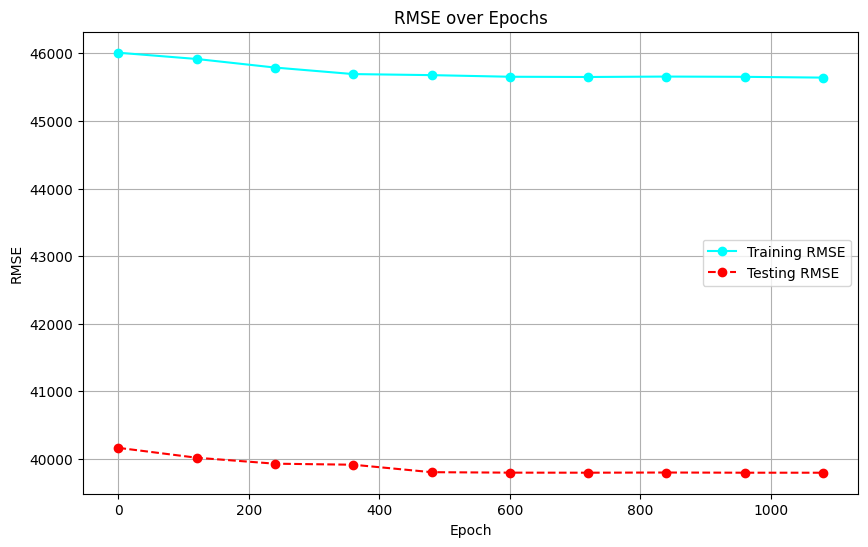

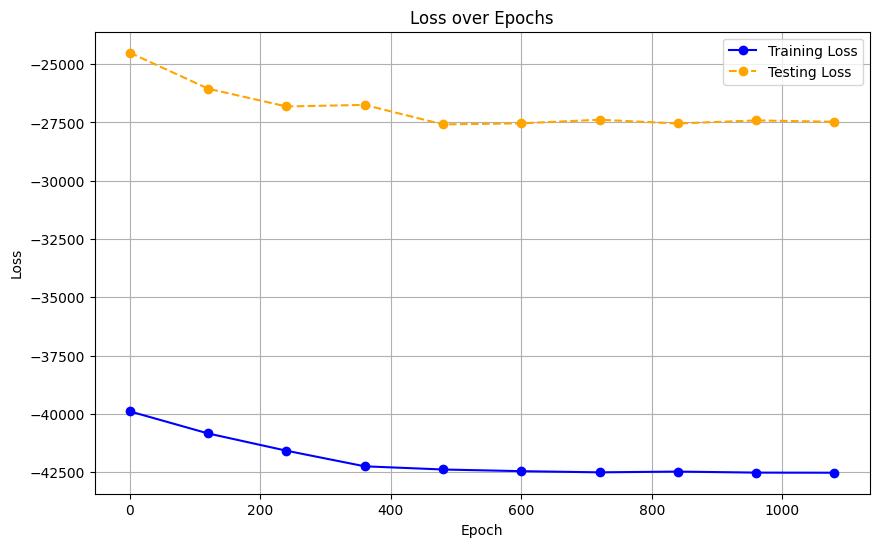

In [38]:
# Access the model data
regressor_model = model_ffnn_detailed["model"]

# Assuming you have your test data loaded and handled correctly
if use_batching_logic:
    X_test = nn_test
    y_test = nn_test.loc[:, ["payment_size"]]
else: 
    X_test = nn_test
    y_test = nn_test.loc[:, ["payment_size"]]

# 1. Accedi all'oggetto del regressore all'interno della pipeline
regressor_model = model_ffnn_detailed["model"]

# 2. Trasforma i dati di test usando solo i passaggi di pre-processing della pipeline
transformer_pipeline = Pipeline(
    steps=[
        ("keep", model_ffnn_detailed.named_steps["keep"]),
        ('zero_to_one', model_ffnn_detailed.named_steps["zero_to_one"]),
    ]
)
X_test_transformed = transformer_pipeline.transform(X_test)

test_loss, testing_rmses = regressor_model.get_testing_losses(X_test_transformed, y_test)

# --- PLOT 1: RMSE ---
plt.figure(figsize=(10, 6))
plt.plot(regressor_model.testing_epochs, regressor_model.training_rmses_history, label="Training RMSE", marker='o', linestyle='-', color='cyan')
plt.plot(regressor_model.testing_epochs, testing_rmses, label="Testing RMSE", marker='o', linestyle='--', color='red')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT 2: LOSS ---
plt.figure(figsize=(10, 6))
plt.plot(regressor_model.testing_epochs, regressor_model.training_losses_history, label="Training Loss", marker='o', linestyle='-', color='blue')
plt.plot(regressor_model.testing_epochs, test_loss, label="Testing Loss", marker='o', linestyle='--', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Above we see two different plots because the RMSE is not the Loss used to train the model, which is a Poisson Loss function.

In [39]:
dat_ffnn_det_pred, triangle_ffnn_detailed = make_pred_set_and_triangle(model_ffnn_detailed, nn_train, nn_test)

The code below performs a comprehensive evaluation of the FFNN model's prediction accuracy by comparing its claims predictions against actual payment values. First, it generates predictions from the trained FFNN model and creates some quantiles (1000 bins) groupings of these predictions to enable analysis at different levels of granularity.

The visualization creates side-by-side comparison plots for training and test datasets, showing the relationship between the model's predicted values (x-axis) and the actual average payments (y-axis) across all prediction quantiles. Each point on the scatter plot represents the average prediction and corresponding average actual payment for a specific percentile bin. The red diagonal line serves as a reference for perfect predictions, where predicted values would exactly match actual payments.

Looking at the results we can see how the FFNN performs well on the first part of the distribution, while there is a bigger distance (between actual and predicted) ove the tail. This can be expected because the amount of data available is less, but is also where a common model like the Chain Ladder does not perferm perfectly.

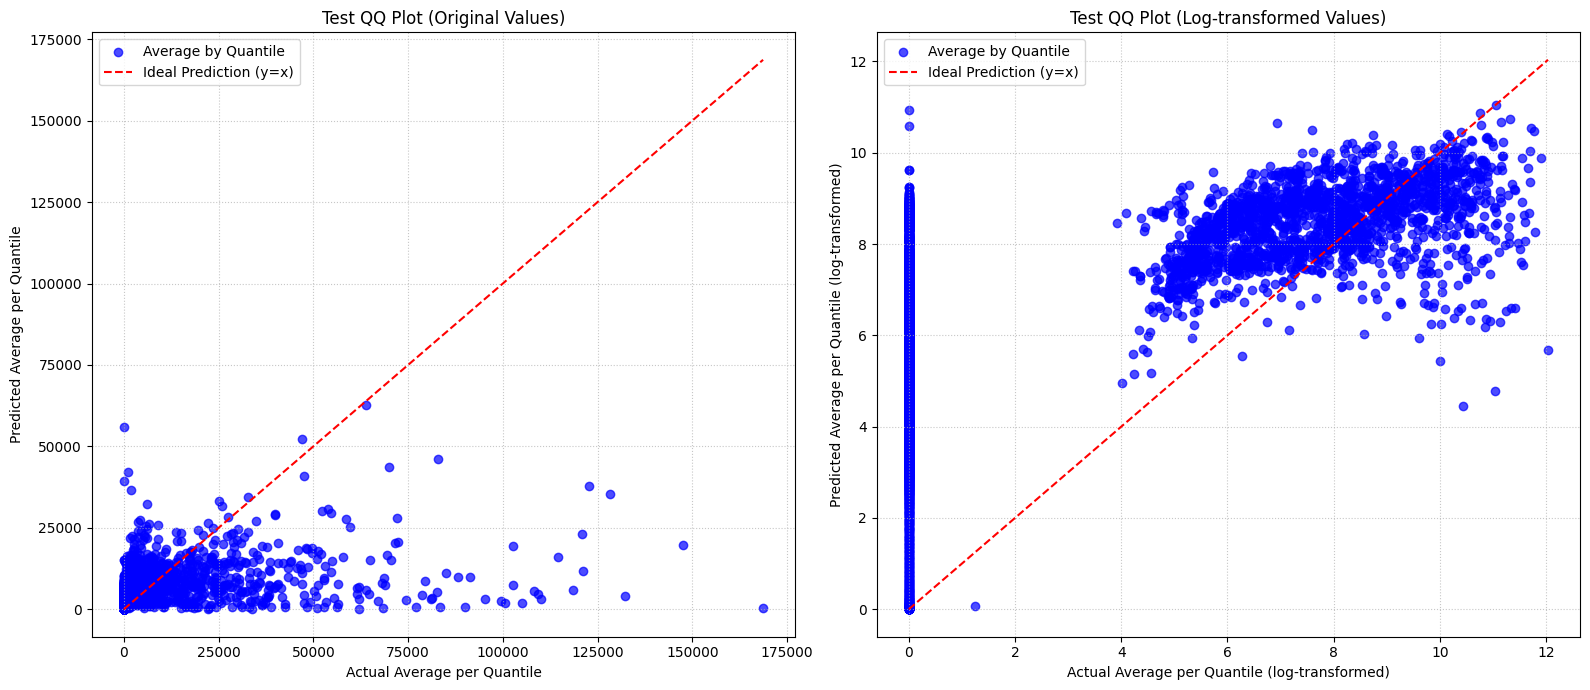

In [40]:
dat["pred_ffnn_claims"] = model_ffnn_detailed.predict(dat)
test_data = dat.loc[dat.train_ind == 0].copy()
test_data["pred_ffnn_claims_quantile"] = pd.qcut(test_data["pred_ffnn_claims"], 5000, labels=False, duplicates='drop') # Group the test set predictions into 1000 quantiles
X_sum_test = test_data.groupby("pred_ffnn_claims_quantile").agg("mean").reset_index() # Calculate the mean for each quantile in the test set

fig, axes = plt.subplots(1, 2, figsize=(16, 7)) #two plots side by side

# --- Plot 1: QQ Plot with Original Values ---
ax1 = axes[0]

max_val = max(X_sum_test['payment_size'].max(), X_sum_test['pred_ffnn_claims'].max())

ax1.scatter(X_sum_test['payment_size'], X_sum_test['pred_ffnn_claims'],
            label='Average by Quantile', color='blue', alpha=0.7)

ax1.plot([0, max_val], [0, max_val],
         color='red', linestyle='--', label='Ideal Prediction (y=x)')

ax1.set_title('Test QQ Plot (Original Values)')
ax1.set_xlabel('Actual Average per Quantile')
ax1.set_ylabel('Predicted Average per Quantile')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# --- Plot 2: QQ Plot with Log Values ---
ax2 = axes[1]

log_pred = np.log1p(X_sum_test['pred_ffnn_claims'])
log_actual = np.log1p(X_sum_test['payment_size'])
max_log_val = max(log_pred.max(), log_actual.max())

ax2.scatter(log_actual, log_pred,
            label='Average by Quantile', color='blue', alpha=0.7)

ax2.plot([0, max_log_val], [0, max_log_val],
         color='red', linestyle='--', label='Ideal Prediction (y=x)')

ax2.set_title('Test QQ Plot (Log-transformed Values)')
ax2.set_xlabel('Actual Average per Quantile (log-transformed)')
ax2.set_ylabel('Predicted Average per Quantile (log-transformed)')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()
plt.tight_layout()
plt.show()

The model shows significant dispersion of predictions around the ideal fit, with this variance appearing more pronounced for higher actual values, indicating a potential systematic underestimation issue in that range

## Gradient Boosting Individual Model
----
The Gradient Boosting Machine (GBM) is an ensemble learning method that builds models sequentially, excelling at both regression and classification tasks.
We implement a GBM model as our baseline for several reasons:
- Ease of Implementation: GBMs typically deliver strong results with minimal tuning
- Predictable Behavior: The model won't produce extreme extrapolations
- Stable Performance: Particularly suitable for our simulated data which lacks complex payment period trends

Note: While GBMs provide reliable baseline performance, their conservative nature means they may not fully capture emerging payment patterns in real-world scenarios with temporal trends

In [41]:
set_seed(seed)

parameters_gbm = {
    "max_iter": [500, 1000, 2000, 5000], 
    "l2_regularization": [0, 0.001, 0.01, 0.1, 0.3],
    "loss": ["poisson"],
    "learning_rate": [0.03, 0.07, 0.1],
    "verbose": [1]  
  #  "early_stopping": [False]
}


gradient_boosting = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),         
        ('gbm', RandomizedSearchCV(
                  HistGradientBoostingRegressor(verbose=1),
                  parameters_gbm,
                  n_jobs=-1, # Run in parallel
                  n_iter=cv_runs, # Models train slowly, so try only a few models
                  cv=RollingOriginSplit(5,5).split(groups=nn_train.payment_period),
                  random_state=0)),
    ]
)

gradient_boosting.fit(
    nn_train,
    nn_train.payment_size
)

#print(gradient_boosting["gbm"].best_params_)

Binning 0.003 GB of training data: 0.025 s
Binning 0.000 GB of validation data: Binning 0.004 GB of training data: Binning 0.004 GB of training data: Binning 0.003 GB of training data: Binning 0.003 GB of training data: Binning 0.003 GB of training data: 0.042 s
Binning 0.000 GB of validation data: 0.026 s
Binning 0.000 GB of validation data: 0.039 s
Binning 0.000 GB of validation data: 0.029 s
Binning 0.000 GB of validation data: 0.033 s
Binning 0.000 GB of validation data: Binning 0.003 GB of training data: Binning 0.004 GB of training data: Binning 0.004 GB of training data: 0.028 s
Binning 0.000 GB of validation data: 0.038 s
Binning 0.000 GB of validation data: 0.041 s
Binning 0.000 GB of validation data: Binning 0.004 GB of training data: Binning 0.003 GB of training data: Binning 0.003 GB of training data: Binning 0.003 GB of training data: 0.038 s
Binning 0.000 GB of validation data: 0.033 s
Binning 0.000 GB of validation data: Binning 0.004 GB of training data: Binning 0.003 G

Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['notidel', 'occurrence_time',
                                    'development_period', 'payment_period',
                                    'has_payment_to_prior_period',
                                    'log1_payment_to_prior_period',
                                    'payment_count_to_prior_period',
                                    'backdate_periods'])),
                ('gbm',
                 RandomizedSearchCV(cv=<generator object RollingOriginSplit.split at 0x733e9e91d900>,
                                    estimator=HistGradientBoostingRegressor(verbose=1),
                                    n_iter=4, n_jobs=-1,
                                    param_distributions={'l2_regularization': [0,
                                                                               0.001,
                                                                               0.01,
                                                                               0.1,
                                                                               0.3],
                                                         'learning_rate': [0.03,
                                                                           0.07,
                                                                           0.1],
                                                         'loss': ['poisson'],
                                                         'max_iter': [500, 1000,
                                                                      2000,
                                                                      5000],
                                                         'verbose': [1]},
                                    random_state=0))])

Train losses: [-36389.3345365  -36786.62618139 -37098.89396623 -37371.85618212
 -37569.78826244 -37744.27428764 -37915.57530723 -38080.00767763
 -38223.85331367 -38342.67749589 -38453.75564425 -38577.26140371
 -38697.44642576 -38816.63470187 -38924.53117269 -39020.20304844
 -39113.75746816 -39200.65298513 -39277.38209592 -39351.46597379
 -39431.46901246 -39506.13142588 -39568.6070721  -39635.08029199
 -39694.54605185 -39756.05733835 -39824.61665737 -39886.98882139
 -39937.64777884 -39990.9093814  -40050.88515535 -40099.91123891
 -40149.35541083 -40210.05944936 -40273.29066757 -40321.36045932
 -40375.88582455 -40438.11049309 -40476.51214127 -40526.49165014
 -40574.78333911 -40616.53880373 -40654.62825471 -40691.06429566
 -40728.06868095 -40768.21961174 -40808.92705997 -40845.34591098
 -40878.71088471 -40911.75491836 -40945.0708547  -40982.37986261
 -41012.71445787 -41037.71330101 -41064.77805016 -41099.0502195
 -41135.57600334 -41162.9880528  -41190.23642897 -41222.06873152
 -41244.0902

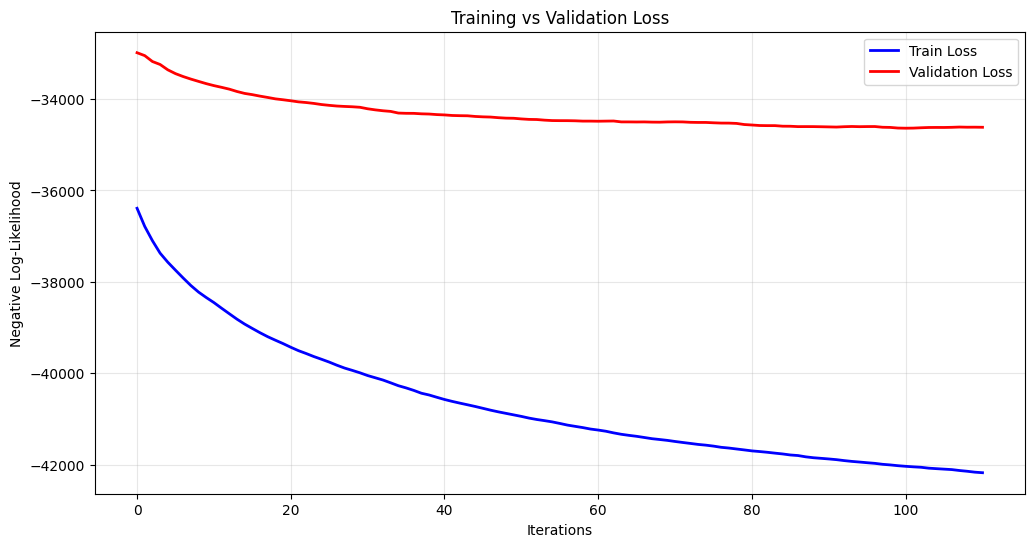

In [42]:
# Dopo il training, ottieni il miglior modello
best_model = gradient_boosting["gbm"].best_estimator_

# Le loss sono già salvate in questi attributi
train_losses = -best_model.train_score_
val_losses = -best_model.validation_score_  # Se c'è early stopping

print("Train losses:", train_losses)
print("Validation losses:", val_losses)

# Plot delle loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
if val_losses is not None:
    plt.plot(val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
dat_gbm_pred, triangle_gbm_ind = make_pred_set_and_triangle(gradient_boosting, nn_train, nn_test)

This visualization follows the same quantile-based evaluation approach we used for the FFNN model, allowing direct comparison of model performance. The Gradient Boosting model's predictions are divided into 1000 quantiles, with each point representing the average prediction and corresponding actual payment within a quantile bin. The red reference line (y=x) again serves as the ideal prediction benchmark. Similar to the FFNN analysis, we examine how closely the points cluster around this line to assess prediction accuracy across different claim value ranges, with separate views for training and test data to evaluate potential overfitting. The consistent quantile methodology enables fair comparison between the two models' performance characteristics.

It is very interesting to see how well the GBM model captures even the extreme values.

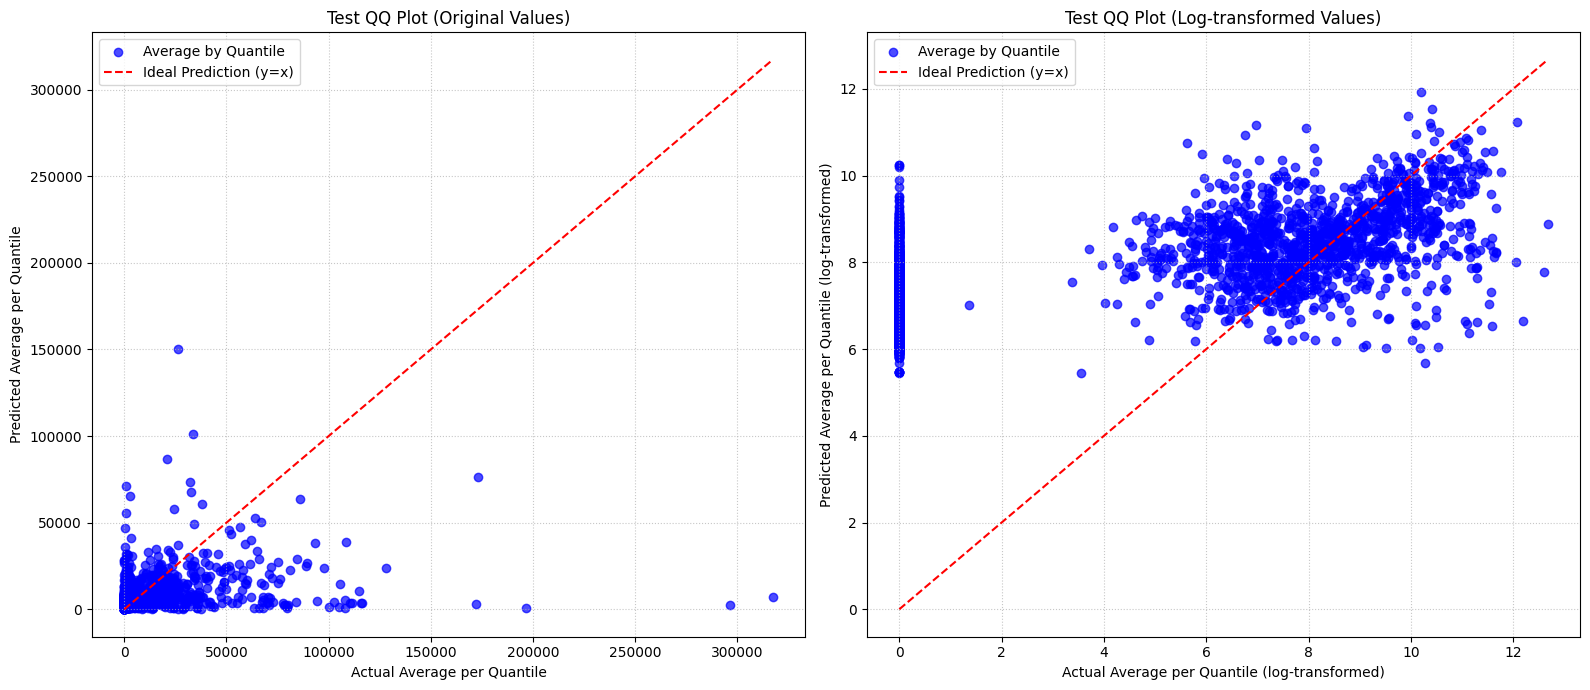

In [44]:
dat["pred_gbm_claims"] = gradient_boosting.predict(dat)
test_data = dat.loc[dat.train_ind == 0].copy()
test_data["pred_gbm_claims_quantile"] = pd.qcut(test_data["pred_gbm_claims"], 5000, labels=False, duplicates='drop') # Group the test set predictions into 1000 quantiles
X_sum_test = test_data.groupby("pred_gbm_claims_quantile").agg("mean").reset_index() # Calculate the mean for each quantile in the test set

fig, axes = plt.subplots(1, 2, figsize=(16, 7)) #two plots side by side

# --- Plot 1: QQ Plot with Original Values ---
ax1 = axes[0]

max_val = max(X_sum_test['payment_size'].max(), X_sum_test['pred_gbm_claims'].max())

ax1.scatter(X_sum_test['payment_size'], X_sum_test['pred_gbm_claims'],
            label='Average by Quantile', color='blue', alpha=0.7)

ax1.plot([0, max_val], [0, max_val],
         color='red', linestyle='--', label='Ideal Prediction (y=x)')

ax1.set_title('Test QQ Plot (Original Values)')
ax1.set_xlabel('Actual Average per Quantile')
ax1.set_ylabel('Predicted Average per Quantile')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# --- Plot 2: QQ Plot with Log Values ---
ax2 = axes[1]

log_pred = np.log1p(X_sum_test['pred_gbm_claims'])
log_actual = np.log1p(X_sum_test['payment_size'])
max_log_val = max(log_pred.max(), log_actual.max())

ax2.scatter(log_actual, log_pred,
            label='Average by Quantile', color='blue', alpha=0.7)

ax2.plot([0, max_log_val], [0, max_log_val],
         color='red', linestyle='--', label='Ideal Prediction (y=x)')

ax2.set_title('Test QQ Plot (Log-transformed Values)')
ax2.set_xlabel('Actual Average per Quantile (log-transformed)')
ax2.set_ylabel('Predicted Average per Quantile (log-transformed)')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()
plt.tight_layout()
plt.show()

The result seems different from the one obtained by the Neural Network model. The GBM seems more in line even on the extreme predictions.

## SHAP (SHapley Additive exPlanations) - GBM VS NN
----

The interpretability of the results is extremely important, therefore this section proposes a method for evaluating the importance of each variable.

A SHAP (SHapley Additive exPlanations) value is a value that represents the contribution of a single feature (characteristic) to a machine learning model's prediction.

In other words, a SHAP value explains why the model made a certain prediction by showing the importance of each variable in the final outcome. If you are comparing two models, SHAP values allow you to see which features are more important for each model and whether the two models rely on similar variables for their predictions.

FFNN

Lista features originale: ['notidel', 'occurrence_time', 'development_period', 'payment_period', 'has_payment_to_prior_period', 'log1_payment_to_prior_period', 'payment_count_to_prior_period', 'backdate_periods']
Features original list: ['notidel', 'occurrence_time', 'development_period', 'payment_period', 'has_payment_to_prior_period', 'log1_payment_to_prior_period', 'payment_count_to_prior_period', 'backdate_periods']


100%|██████████| 1000/1000 [00:08<00:00, 113.82it/s]
<positron-console-cell-45>:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


=== SHAP ANALYSIS ===
Observation Number: 1000
Features Number: 8

TOP 10 FEATURES:
                         feature  importance
5   log1_payment_to_prior_period   17,379.39
6  payment_count_to_prior_period   14,507.43
4    has_payment_to_prior_period    4,083.16
2             development_period    4,047.53
3                 payment_period    1,009.72
7               backdate_periods      889.02
0                        notidel      377.19
1                occurrence_time       13.55


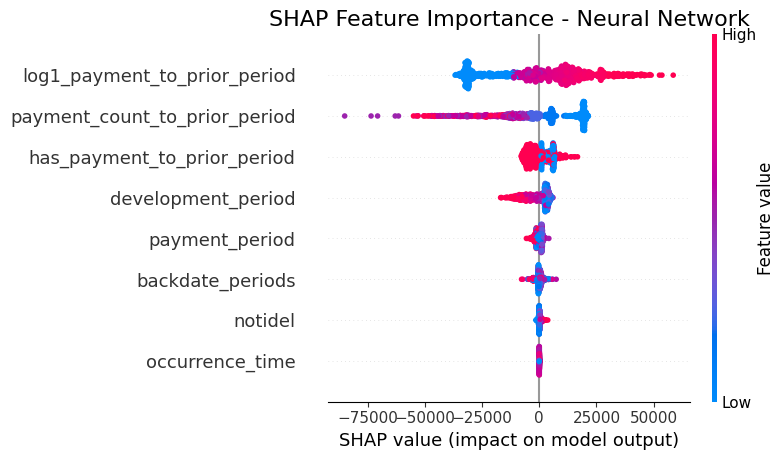

<positron-console-cell-45>:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


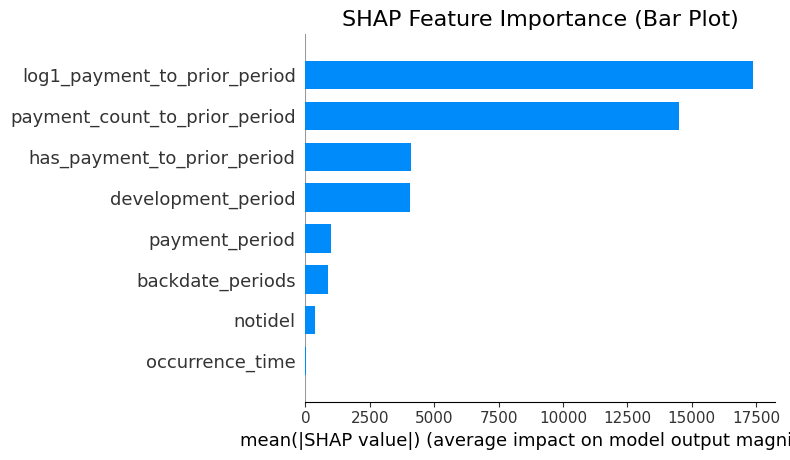

In [45]:
print("Lista features originale:", features)

try:
    feature_names = model_ffnn_detailed["keep"].features
    print("Features da ColumnKeeper:", feature_names)
except AttributeError:
    try:
        feature_names = model_ffnn_detailed["keep"].get_feature_names_out()
        print("Features da get_feature_names_out():", feature_names)
    except:
        feature_names = features 
        print("Features original list:", feature_names)

# data preparation
best_nn_model = model_ffnn_detailed["model"]
X_processed = model_ffnn_detailed["zero_to_one"].transform(
    model_ffnn_detailed["keep"].transform(nn_train)
)

if hasattr(X_processed, 'values'):
    X_processed = X_processed.values

# check on dimensions
if len(feature_names) != X_processed.shape[1]:
    print(f"Attention: {len(feature_names)} features names but {X_processed.shape[1]} columns!")
    
    feature_names = feature_names[:X_processed.shape[1]]
    print("Feature names:", feature_names)

def predict_fn(X):
    if hasattr(X, 'values'):
        X = X.values
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    return best_nn_model.predict(X)

# SHAP
explainer = shap.KernelExplainer(predict_fn, X_processed[:100])
shap_values = explainer.shap_values(X_processed[:1000])

print("=== SHAP ANALYSIS ===")
print(f"Observation Number: {len(shap_values)}")
print(f"Features Number: {len(feature_names)}")

# Feature importance 
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTOP 10 FEATURES:")
print(shap_df.head(10))

# Plot 
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_processed[:1000], 
                 feature_names=feature_names, show=False)
plt.title('SHAP Feature Importance - Neural Network', fontsize=16)
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_processed[:1000], 
                 feature_names=feature_names, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar Plot)', fontsize=16)
plt.tight_layout()
plt.show()

The results show that has_incurred_to_prior_period is the model's most influential feature. Other features related to prior payments and balances, such as log1_payment_to_prior_period and log1_outstanding_to_prior_period, are also highly important, indicating that payment history is a key driver of the model's decisions.

GBM

<positron-console-cell-46>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


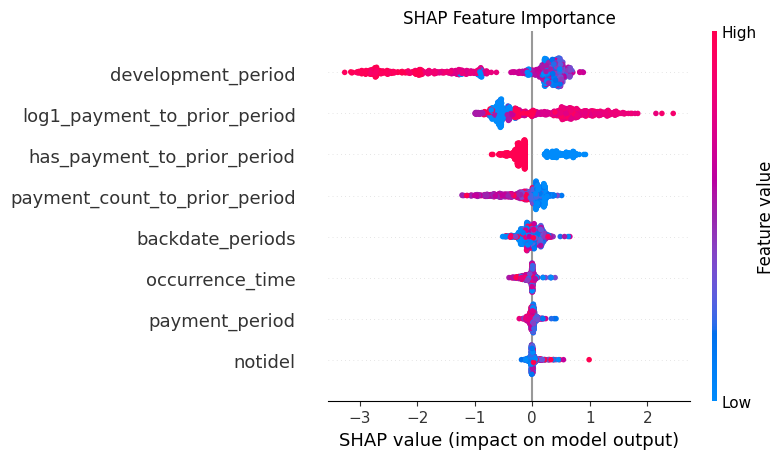

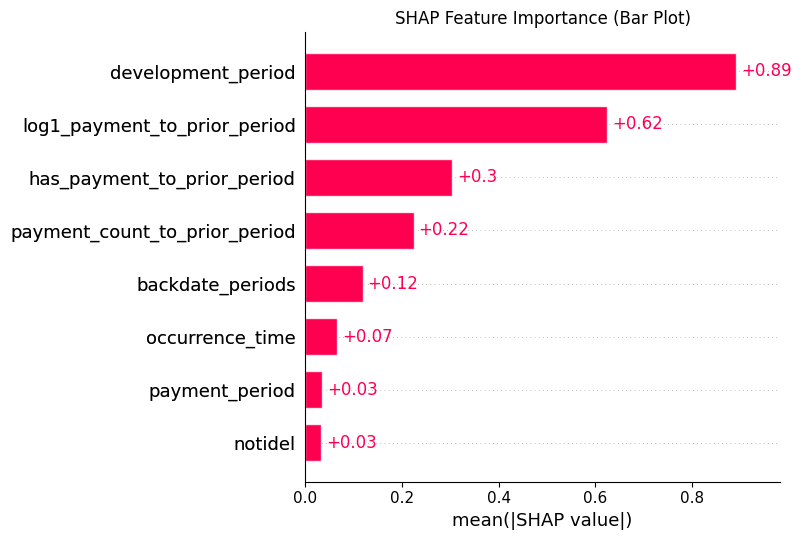

In [46]:
best_model = gradient_boosting["gbm"].best_estimator_
X_processed = gradient_boosting["keep"].transform(nn_train)

# SHAP expaliner creation
explainer = shap.Explainer(best_model, X_processed)

# SHAP Calculation
shap_values = explainer(X_processed[:1000])  # Prime 1000 osservazioni

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_processed[:1000], show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

The GBM model heavily relies on log1_outstanding_to_prior_period for its predictions Other key drivers include has_incurred_to_prior_period and development_period.
 Unlike the neural network, the GBM places a higher emphasis on outstanding balance and development period over the simple binary indicator.

Despite their very different architectures, both models arrived at a similar conclusion about the most important features. In both cases, the primary drivers for the prediction are variables related to past claims (has_incurred_to_prior_period) and financial conditions from the prior period (log1_outstanding_to_prior_period, log1_payment_to_prior_period). This suggests that financial history and claim status are very strong signals that transcend the differences between the algorithms.


The crucial difference between FFNN and the GBM is not in which features are most important, but in their ranking and interaction.

The neural network places has_incurred_to_prior_period as the number one feature. Its SHAP plot shows a very clear, almost binary impact. This indicates that the FFNN is leveraging a strong, simple signal, almost like an "if-then" rule, for its predictions. More quantitative variables like the logs of payments and balances are important but take a backseat to this binary indicator.

Gradient Boosting Machine (GBM): The GBM, on the other hand, considers log1_outstanding_to_prior_period as the most influential feature. This suggests that the model is learning a more nuanced, continuous relationship: the importance of the contribution is not just "yes or no," but is proportional to the magnitude of the outstanding balance. Additionally, the GBM places a much higher importance on development_period than the FFNN, showing it considers the claim's development phase a more critical factor.

In summary, the FFNN relies on a strong, simple binary rule as its primary decision-making factor, while the GBM builds its judgment on more gradual and quantitative relationships related to the outstanding balance and development time. This diversity reflects the different approaches the two models take to extract information from the data.

## Ultimate Summary - GBM VS NN
----

Now we compare the ultimate projections from the different models: despite looking the QQ Plot of the amount shows a different behavior in the tails, the plot below shows a similar fit of the overall payments by occurrence period.

In [47]:
pd.options.display.float_format = '{:,.0f}'.format

results = pd.concat(
    [(
        triangle.loc[lambda df: df.payment_period == cutoff, ["occurrence_period", "payment_size_cumulative"]]
        .set_index("occurrence_period")
        .rename(columns={"payment_size_cumulative": "Paid to Date"})
    )] +
    [(df.loc[lambda df: df.development_period == num_dev_periods, ["occurrence_period", "payment_size_cumulative"]]
        .set_index("occurrence_period")
        .rename(columns={"payment_size_cumulative": l})) for df, l in zip(
            [triangle,         round(triangle_cl),  round(triangle_ffnn_detailed), round(triangle_gbm_ind)],
            ["True Ultimate", "Chain Ladder",      "Detailed FFNN",  "Detailed GBM"]
        )
    ],
    axis="columns"
).sort_index()

results

,Paid to Date,True Ultimate,Chain Ladder,Detailed FFNN,Detailed GBM
occurrence_period,,,,,
1,"14,076,384","14,076,384","14,076,384","14,076,384","14,076,384"
2,"12,657,557","12,657,557","12,657,559","12,677,187","12,677,171"
3,"13,146,049","13,146,049","13,146,049","13,201,550","13,188,247"
4,"15,438,633","15,509,786","15,438,632","15,533,623","15,493,801"
5,"16,169,320","16,169,320","16,169,319","16,356,939","16,253,763"
6,"16,819,210","16,819,210","16,819,208","17,088,751","16,947,135"
7,"13,773,029","13,773,029","13,879,979","14,007,448","13,898,644"
8,"21,912,546","21,912,546","22,184,680","22,423,331","22,118,891"
9,"15,770,283","17,388,102","16,012,689","16,320,154","15,992,032"


In the following tables we show the %error for each period and the total one.
Here we can see how both GBM and the FFNN perform better overall than chain ladder; in particular, it seems that the real added value lies in the tail points (always considering the occurrence period). Specifically, GBM shows better performance than the Neural Network.

In [34]:
pd.options.display.float_format = '{:,.2f}%'.format


true_ultimate_df = triangle.loc[
    lambda df: df.development_period == num_dev_periods,
    ["occurrence_period", "payment_size_cumulative"]
].set_index("occurrence_period").rename(columns={"payment_size_cumulative": "True Ultimate"})

model_results = [true_ultimate_df]

for df, label in zip(
    [triangle_cl, triangle_ffnn_detailed, triangle_gbm_ind],
    ["Chain Ladder", "Detailed FFNN", "Detailed GBM"]
):
    model_df = df.loc[
        lambda x: x.development_period == num_dev_periods,
        ["occurrence_period", "payment_size_cumulative"]
    ].set_index("occurrence_period").rename(columns={"payment_size_cumulative": label})
    model_results.append(model_df)

combined_results = pd.concat(model_results, axis="columns").sort_index()


if "True Ultimate" in combined_results.columns:
    combined_results["Chain Ladder % Var"] = ((combined_results["Chain Ladder"] - combined_results["True Ultimate"]) / combined_results["True Ultimate"]) * 100
    combined_results["Detailed FFNN % Var"] = ((combined_results["Detailed FFNN"] - combined_results["True Ultimate"]) / combined_results["True Ultimate"]) * 100
    combined_results["Detailed GBM % Var"] = ((combined_results["Detailed GBM"] - combined_results["True Ultimate"]) / combined_results["True Ultimate"]) * 100

    final_variation_table = combined_results[[
        "Chain Ladder % Var",
        "Detailed FFNN % Var",
        "Detailed GBM % Var"
    ]]
    final_variation_table = final_variation_table.reset_index()
    final_variation_table.rename(columns={'occurrence_period': 'Occurrence Period'}, inplace=True)
else:
    print("Error")
    final_variation_table = pd.DataFrame()


print("=== Average Error Percentage (Absolute Value) for Each Period ===")
display(final_variation_table.style.set_properties(**{
    'text-align': 'center',
    'border': '1px solid #dddddd'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#2c3e50'),
        ('color', 'white'),
        ('font-weight', 'bold')
    ]},
    {'selector': 'td', 'props': [
        ('background-color', '#f9f9f9')
    ]},
    {'selector': 'tr:hover td', 'props': [
        ('background-color', '#e6f3ff')
    ]}
]).format({
    "Chain Ladder % Var": '{:,.2f}%',
    "Detailed FFNN % Var": '{:,.2f}%',
    "Detailed GBM % Var": '{:,.2f}%'
}))



if not final_variation_table.empty:
   
    error_summary = final_variation_table[[col for col in final_variation_table.columns if ' % Var' in col]].abs().mean()
    error_summary_df = pd.DataFrame(error_summary, columns=["AV Error %"])
    error_summary_df.index = [idx.replace(' % Var', '') for idx in error_summary_df.index]
    error_summary_df.index.name = "Model"

    print("\n=== Average Error Percentage (Absolute Value) over All Periods ===")
    display(error_summary_df.style.set_properties(**{
        'text-align': 'center',
        'border': '1px solid #dddddd'
    }).set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#2c3e50'),
            ('color', 'white'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f9f9f9')
        ]},
        {'selector': 'tr:hover td', 'props': [
            ('background-color', '#e6f3ff')
        ]}
    ]).format({
        "AV Error %": '{:,.2f}%' 
    }))
else:
    print("\nIt is not possible to calculate the average percentage error because the variation table is empty.")

=== Average Error Percentage (Absolute Value) for Each Period ===


,Occurrence Period,Chain Ladder % Var,Detailed FFNN % Var,Detailed GBM % Var
0,1,0.00%,-0.00%,-0.00%
1,2,0.00%,0.00%,0.22%
2,3,0.00%,0.00%,0.45%
3,4,-0.46%,-0.42%,0.05%
4,5,-0.00%,0.00%,0.71%
5,6,-0.00%,0.00%,1.00%
6,7,0.78%,0.00%,1.27%
7,8,1.24%,0.00%,1.13%
8,9,-7.91%,-8.43%,-7.91%
9,10,-2.06%,-4.59%,-3.34%



=== Average Error Percentage (Absolute Value) over All Periods ===


,AV Error %
Model,
Chain Ladder,11.93%
Detailed FFNN,10.15%
Detailed GBM,12.44%


Below we plot the results of the table in order to show in graphical way what we've seen in the numbers.
We can see the moment when the difference between the FFNN and GBM forecasts is biggest, around periods 25-35.

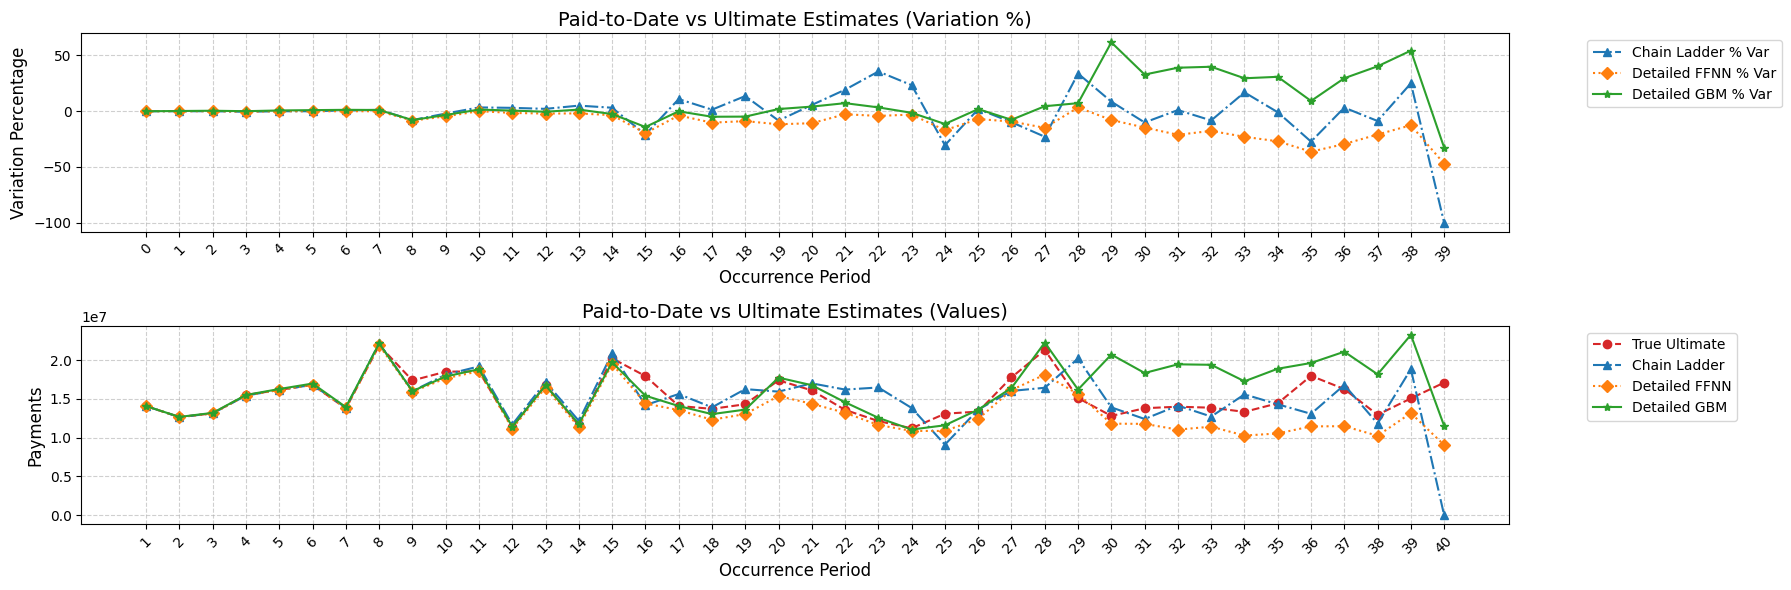

In [35]:
# Define consistent style for each method
style_mapping = {
    'Chain Ladder': {'color': '#1f77b4', 'marker': '^', 'linestyle': '-.'},  # blue
    'Detailed FFNN': {'color': '#ff7f0e', 'marker': 'D', 'linestyle': ':'},  # orange
    'Detailed GBM': {'color': '#2ca02c', 'marker': '*', 'linestyle': '-'},  # green
    'True Ultimate': {'color': '#d62728', 'marker': 'o', 'linestyle': '--'}  # red
}


# Create figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18, 6))

#  Variation Comparison

ax1.plot(final_variation_table.index, final_variation_table['Chain Ladder % Var'],
         **style_mapping['Chain Ladder'], label='Chain Ladder % Var')
ax1.plot(final_variation_table.index, final_variation_table['Detailed FFNN % Var'],
         **style_mapping['Detailed FFNN'], label='Detailed FFNN % Var')
ax1.plot(final_variation_table.index, final_variation_table['Detailed GBM % Var'],
         **style_mapping['Detailed GBM'], label='Detailed GBM % Var')

ax1.set_title('Paid-to-Date vs Ultimate Estimates (Variation %)', fontsize=14)
ax1.set_xlabel('Occurrence Period', fontsize=12)
ax1.set_ylabel('Variation Percentage', fontsize=12)
ax1.set_xticks(final_variation_table.index)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

#  Ultimate Comparisons

ax2.plot(results.index, results['True Ultimate'],
         **style_mapping['True Ultimate'], label='True Ultimate')
ax2.plot(results.index, results['Chain Ladder'],
         **style_mapping['Chain Ladder'], label='Chain Ladder')
ax2.plot(results.index, results['Detailed FFNN'],
         **style_mapping['Detailed FFNN'], label='Detailed FFNN')
ax2.plot(results.index, results['Detailed GBM'],
         **style_mapping['Detailed GBM'], label='Detailed GBM')

ax2.set_title('Paid-to-Date vs Ultimate Estimates (Values)', fontsize=14)
ax2.set_xlabel('Occurrence Period', fontsize=12)
ax2.set_ylabel('Payments', fontsize=12)
ax2.set_xticks(results.index)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Individual Claim Dataset with Prediction Building
----

The idea is to add the individual predictions on the main dataset in order to evaluate the performance on the individual claim instead of at an aggregate level.
As first step we create a database which contains the original data with three additional columns with the predictions of the different models: Chain Ladder, FFNN and GBM; this dataset will be the base level for some analysis on the individual claim.

One of the strengths of neural networks and GBM models is that they provide better predictions at the individual level than at the aggregate level. Therefore, in this section, we will attempt to measure performance at the individual level to highlight this aspect.

In the real world this means that, if there are different types of claims or different features, individual models should perform better in assigning the correct developments to each one - instead the Chain Ladder method is only able to provide an aggregate indication about the total amount.

It is also true that there are not many features in this dataset, so it is difficult discuss properly this part.

In [36]:
# ## Individual Claim Predictions
last_known_payment = dat.loc[dat.train_ind == True] \
                          .groupby('claim_no') \
                          .agg(
                              last_payment_size=('payment_size', 'last'),
                              last_dev_period=('development_period', 'last')
                          ).reset_index()

# Handle new claims with no payments yet. Their last_payment_size is 0.
last_known_payment = last_known_payment.fillna(0)
factors_to_ultimate_df = df_cdf.copy()
factors_to_ultimate_df = factors_to_ultimate_df.rename(columns={'factor_to_ultimate': 'cl_factor_to_ultimate'})
factors_to_ultimate_df.index.name = 'development_period'
factors_to_ultimate_df = factors_to_ultimate_df.reset_index()

cl_predictions = last_known_payment.merge(factors_to_ultimate_df[['development_period', 'cl_factor_to_ultimate']],
                                          how='left',
                                          left_on='last_dev_period',
                                          right_on='development_period')

# Fill NaNs for claims with last_dev_period > max(development_period)
cl_predictions['cl_factor_to_ultimate'] = cl_predictions['cl_factor_to_ultimate'].fillna(1.0)
cl_predictions = cl_predictions.drop(columns=['development_period'])

# Calculate the ultimate prediction for each claim
cl_predictions['cl_ultimate_prediction'] = cl_predictions['last_payment_size'] * cl_predictions['cl_factor_to_ultimate']

dat_with_cl = dat.merge(cl_predictions[['claim_no', 'cl_ultimate_prediction']], how='left', on='claim_no')

dat_with_cl['cl_ultimate_prediction'] = np.where(dat_with_cl['train_ind'] == False, 0, dat_with_cl['cl_ultimate_prediction'])
dat_with_cl['cl_ultimate_prediction'] = dat_with_cl['cl_ultimate_prediction'].fillna(0)

# Calculate the incremental predictions for each period
df_cdf_incr = df_cdf.copy()
df_cdf_incr.index.name = 'development_period'
df_cdf_incr = df_cdf_incr.reset_index()

dat_with_cl = dat_with_cl.merge(df_cdf_incr[['development_period', 'incr_perc_of_ultimate']], how='left', on='development_period')
dat_with_cl['incr_perc_of_ultimate'] = dat_with_cl['incr_perc_of_ultimate'].fillna(0)

dat_with_cl['chain_ladder_prediction_incremental'] = np.where(
    dat_with_cl['payment_period'] > cutoff,
    dat_with_cl['cl_ultimate_prediction'] * dat_with_cl['incr_perc_of_ultimate'],
    dat_with_cl['payment_size']
)

# Clean up temporary columns
dat_with_cl = dat_with_cl.drop(columns=['cl_ultimate_prediction', 'incr_perc_of_ultimate'])

dat_with_cl['pred_ffnn_claims'] = model_ffnn_detailed.predict(dat_with_cl)
dat_with_cl['pred_gbm_claims'] = gradient_boosting.predict(dat_with_cl)

# Create the final granular dataset with all predictions
granular_predictions = dat_with_cl[[
    'claim_no', 'occurrence_period', 'development_period',
    'payment_period', 'payment_size', 'train_ind',
    'chain_ladder_prediction_incremental', 'pred_ffnn_claims', 'pred_gbm_claims'
]].copy()

granular_predictions.rename(columns={
    'payment_size': 'actual_payment_incremental',
    'pred_ffnn_claims': 'ffnn_prediction_incremental',
    'pred_gbm_claims': 'gbm_prediction_incremental'
}, inplace=True)

print("Final Granular Dataset with All Model Predictions:")
display(granular_predictions.head())

Final Granular Dataset with All Model Predictions:


,claim_no,occurrence_period,development_period,payment_period,actual_payment_incremental,train_ind,chain_ladder_prediction_incremental,ffnn_prediction_incremental,gbm_prediction_incremental
0,1,1,1,2,0.00%,True,0.00%,971.22%,615.12%
1,1,1,2,3,0.00%,True,0.00%,"1,743.66%","2,499.19%"
2,1,1,3,4,0.00%,True,0.00%,"1,898.60%","2,834.57%"
3,1,1,4,5,0.00%,True,0.00%,"2,067.30%","3,161.51%"
4,1,1,5,6,"13,226.34%",True,"13,226.34%","2,251.00%","3,414.80%"


## Individual Claim Level Loss
----
Here we evaluate the RMSE on the test part of the dataset to quantify the loss for each model.
In this part we show the losses for each occurrence period and for each development month.

In [37]:
# Filter for test data only (the part of the triangle we are predicting)
test_data = granular_predictions[granular_predictions['train_ind'] == False].copy()

if test_data.empty:
    print("The test set is empty. Performance evaluation is not possible.")
else:
    # Calculate the squared error for each model
    test_data['sq_err_cl'] = (test_data['chain_ladder_prediction_incremental'] - test_data['actual_payment_incremental'])**2
    test_data['sq_err_ffnn'] = (test_data['ffnn_prediction_incremental'] - test_data['actual_payment_incremental'])**2
    test_data['sq_err_gbm'] = (test_data['gbm_prediction_incremental'] - test_data['actual_payment_incremental'])**2
    
    # Aggregate the squared errors by 'occurrence_period' and calculate the RMSE
    rmse_by_period = test_data.groupby('occurrence_period')[['sq_err_cl', 'sq_err_ffnn', 'sq_err_gbm']].mean()

    # Aggregate the squared errors by 'development' and calculate the RMSE
    rmse_by_development = test_data.groupby('development_period')[['sq_err_cl', 'sq_err_ffnn', 'sq_err_gbm']].mean()
    
    rmse_by_period = np.sqrt(rmse_by_period)
    rmse_by_development = np.sqrt(rmse_by_development)

    rmse_by_period.rename(columns={
        'sq_err_cl': 'RMSE_Chain_Ladder',
        'sq_err_ffnn': 'RMSE_ffnn',
        'sq_err_gbm': 'RMSE_GBM'
    }, inplace=True)

    rmse_by_development.rename(columns={
        'sq_err_cl': 'RMSE_Chain_Ladder',
        'sq_err_ffnn': 'RMSE_ffnn',
        'sq_err_gbm': 'RMSE_GBM'
    }, inplace=True)
    

    # RMSE (on the entire test set)
    total_rmse = pd.DataFrame({
        'RMSE_Chain_Ladder': [np.sqrt(test_data['sq_err_cl'].mean())],
        'RMSE_ffnn': [np.sqrt(test_data['sq_err_ffnn'].mean())],
        'RMSE_GBM': [np.sqrt(test_data['sq_err_gbm'].mean())]
    }, index=['Total RMSE'])

    print("\n## Overall Performance Summary\n")
    display(total_rmse)


## Overall Performance Summary



,RMSE_Chain_Ladder,RMSE_ffnn,RMSE_GBM
Total RMSE,"40,184.61%","38,245.49%","38,586.68%"


Below the RMSE by Occurrence Period, calculated on test data:

In [38]:
print("## RMSE by Occurrence Period (on test data)\n")
display(rmse_by_period)

## RMSE by Occurrence Period (on test data)



,RMSE_Chain_Ladder,RMSE_ffnn,RMSE_GBM
occurrence_period,,,
2,0.00%,0.09%,326.15%
3,0.00%,0.11%,329.34%
4,"4,621.88%","4,459.39%","4,605.00%"
5,0.00%,0.13%,329.52%
6,0.00%,0.13%,324.49%
7,0.00%,0.15%,330.81%
8,0.00%,0.15%,326.49%
9,"53,759.08%","52,538.30%","53,666.22%"
10,"30,573.89%","30,007.64%","30,555.71%"


Below the RMSE by Development Period, calculated on test data:

In [39]:
print("## RMSE by Development Period (on test data)\n")
display(rmse_by_development)

## RMSE by Development Period (on test data)



,RMSE_Chain_Ladder,RMSE_ffnn,RMSE_GBM
development_period,,,
1,"1,250.97%","1,590.99%","1,732.83%"
2,"2,340.69%","2,111.07%","2,320.72%"
3,"3,695.88%","3,191.66%","3,796.49%"
4,"8,509.91%","7,374.28%","7,564.10%"
5,"10,906.35%","9,741.59%","10,259.74%"
6,"29,377.81%","27,704.60%","25,904.60%"
7,"25,388.76%","22,979.23%","19,395.84%"
8,"13,575.17%","12,862.14%","13,596.18%"
9,"25,734.98%","23,427.12%","22,841.22%"


Below we plot the results of the RMSE by Occurrence and by Development period.

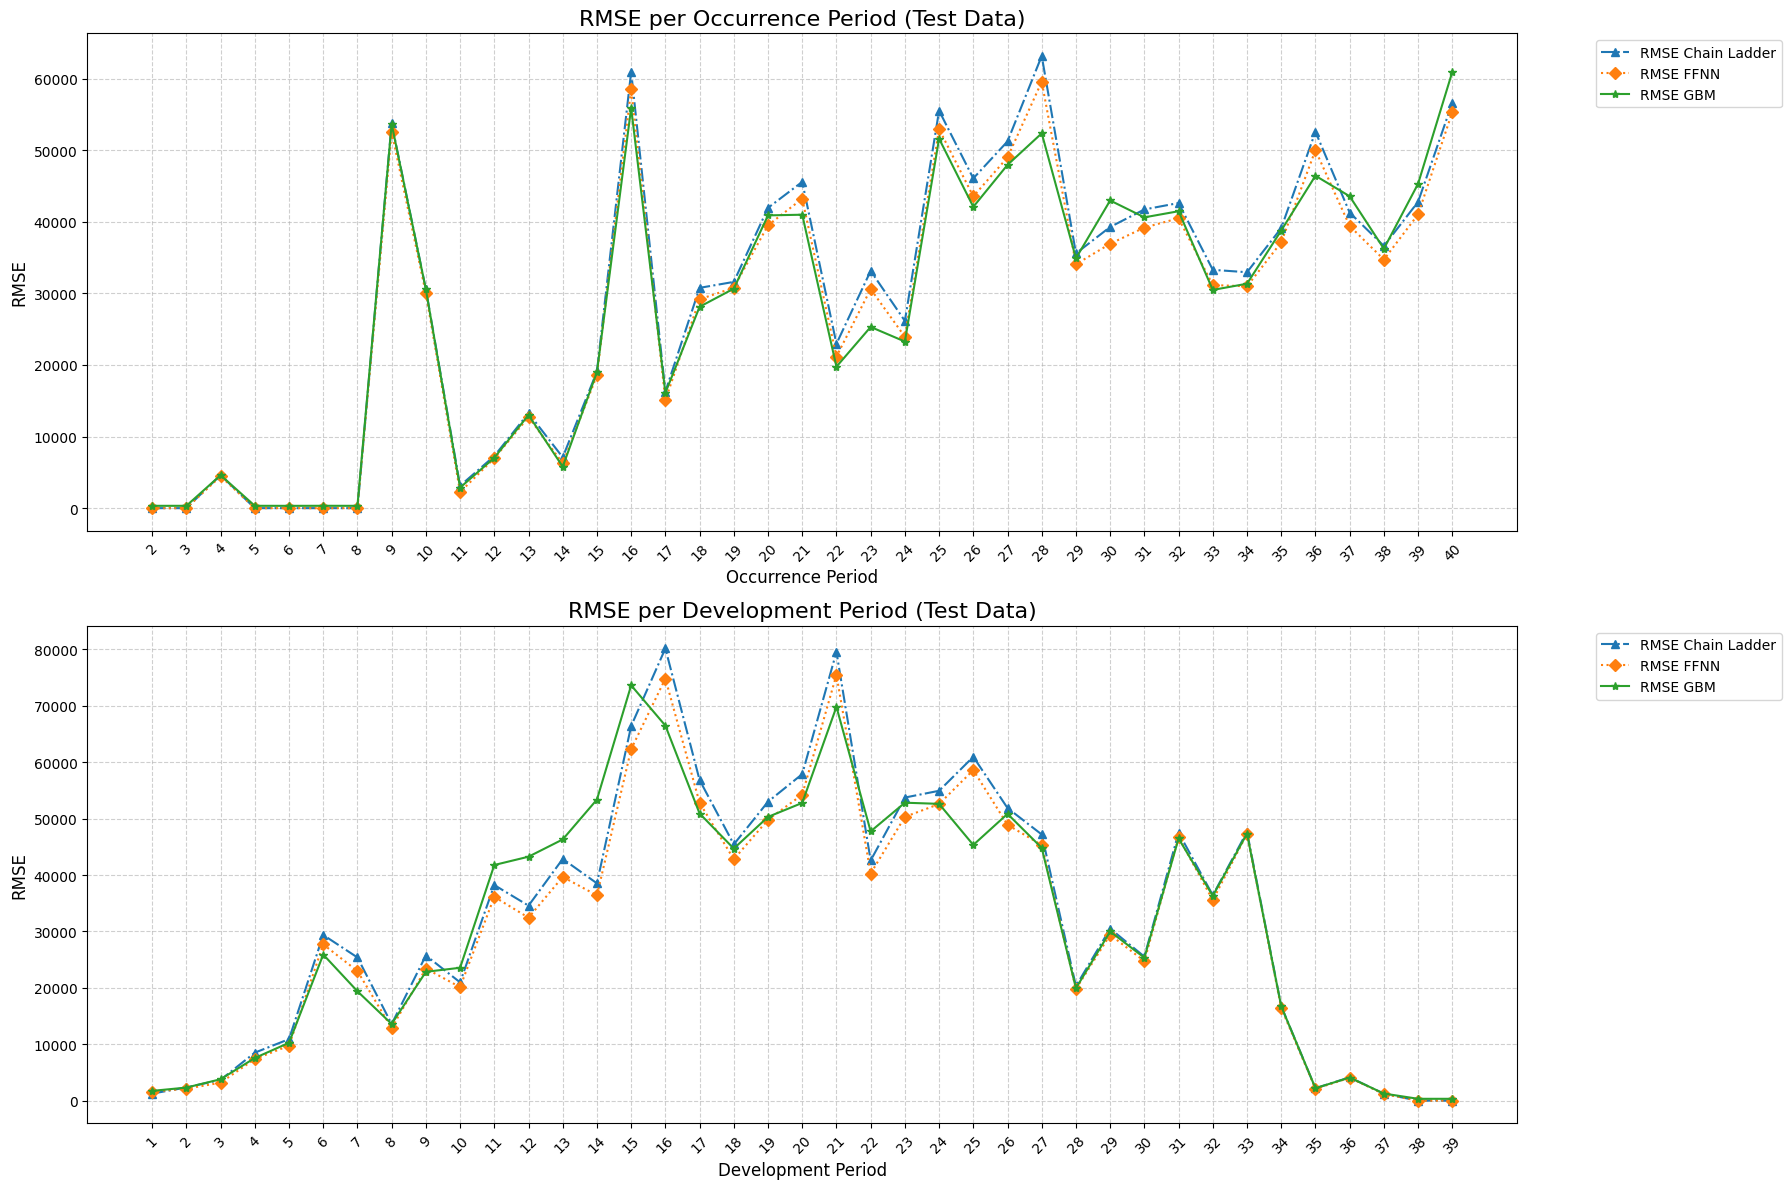

In [40]:
style_mapping = {
    'RMSE_Chain_Ladder': {'color': '#1f77b4', 'marker': '^', 'linestyle': '-.'},  # blue
    'RMSE_ffnn': {'color': '#ff7f0e', 'marker': 'D', 'linestyle': ':'},  # orange
    'RMSE_GBM': {'color': '#2ca02c', 'marker': '*', 'linestyle': '-'},  # green
}

# Create figure with two side-by-side subplots (due in questo caso, uno sopra l'altro)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))


# Plot 1: RMSE by Occurrence Period

ax1.plot(rmse_by_period.index, rmse_by_period['RMSE_Chain_Ladder'],
         **style_mapping['RMSE_Chain_Ladder'], label='RMSE Chain Ladder')
ax1.plot(rmse_by_period.index, rmse_by_period['RMSE_ffnn'],
         **style_mapping['RMSE_ffnn'], label='RMSE FFNN')
ax1.plot(rmse_by_period.index, rmse_by_period['RMSE_GBM'],
         **style_mapping['RMSE_GBM'], label='RMSE GBM')

ax1.set_title('RMSE per Occurrence Period (Test Data)', fontsize=16)
ax1.set_xlabel('Occurrence Period', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_xticks(rmse_by_period.index)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# RMSE by Development Period

ax2.plot(rmse_by_development.index, rmse_by_development['RMSE_Chain_Ladder'],
         **style_mapping['RMSE_Chain_Ladder'], label='RMSE Chain Ladder')
ax2.plot(rmse_by_development.index, rmse_by_development['RMSE_ffnn'],
         **style_mapping['RMSE_ffnn'], label='RMSE FFNN')
ax2.plot(rmse_by_development.index, rmse_by_development['RMSE_GBM'],
         **style_mapping['RMSE_GBM'], label='RMSE GBM')

ax2.set_title('RMSE per Development Period (Test Data)', fontsize=16)
ax2.set_xlabel('Development Period', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_xticks(rmse_by_development.index)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The error increases as the period of occurrence increases. This happens because there is less information available for more recent periods, and claims are projected almost from scratch.
Another interesting result relates to the RMSE trend compared to development periods. It might be intuitive to think that losses increase as development periods increase, due to the availability of data (there is little information at the tail ends, so volatility is high), but this is not the case. One possible reason is that RMSE measures variation in terms of absolute value rather than percentage, so since incremental payments will be much lower, the absolute error will also be lower.
The improvements obtained by the GBM and NN models are mainly in the early development periods (1-26), contrary to what was observed for the occurrence periods for which the improvements are in the range 25-40.

## Conclusions
----

In this notebook, we compared three models: Chain Ladder, commonly used in literature, a Feed Forward Neural Network, and a GBM tree model.

We analyzed the performance of these models both at an aggregate level, comparing the results of the models across all data, and at the individual claim level, focusing on test data and individual losses.

Among the most interesting results, we note that—using a view based on occurrence periods — both the improvements achieved by FFNN and GBM models are significant and are mainly in the last periods where the errors are greatest. As mentioned above, this makes sense because there is less data in these periods and the “individual” models make better use of the information available to them.

Looking at the results by development period, however, improvements in terms of RMSE are noticeable especially in the early periods and not in the later ones. Although this may seem counterintuitive, this result stems from the fact that RMSE measures absolute error (rather than percentage error), so with fewer incremental payments in the later development periods, the absolute possibility of error will also be lower.

Overall, FFNN and GBM consistently outperform Chain Ladder, and GBM in particular also outperforms FFNN.

The reasons for which the GBM overperform the FFNN seems strictly related to the different architecture of the algorithm, which use different features as key driver for the predictions.
Its decision tree architecture makes it particularly effective at capturing complex interactions between features and generalizing better on limited datasets, additionally, GBMs are more robust to outliers, which can negatively impact the performance of neural networks.

Looking at the QQ-plots, an additional advantage for the GBM is its lower error dispersion. While the RMSE values may be similar, the GBM's quantiles are more closely aligned with the actual data, indicating a tighter distribution of errors. The FFNN, on the other hand, shows greater dispersion in its results.

It's important to note that the proposed methods, particularly the Feed-Forward Neural Network and the GBM model, introduce a component of variability due to the stochastic nature of their algorithms, which can depend on the random seed used. Consequently, results may vary slightly between different runs. However, the analyses conducted by the authors have consistently confirmed that the performance of the GBM and FFNN models is significantly superior to that of the traditional Chain Ladder method.

